In [2]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt

In [3]:
import gurobipy as gp
from gurobipy import GRB

options = {
    "WLSACCESSID": "31598bc4-0b23-474f-86d4-af032d437137",
    "WLSSECRET": "bd7ad348-f8d6-452e-b615-ebc88d920e41",
    "LICENSEID": 2498404,
}

### Linear Programming Problem
min $d+\sum_{n=1}^{N_1}\lambda_{n,1}\Pi_{n,1}+\sum_{n=1}^{N_2}\lambda_{n,2}\Pi_{n,2}$

s.t. $d+\sum_{n=1}^{N_1}\lambda_{n,1}(S_1^i-K_{n,1})^++\sum_{n=1}^{N_2}\lambda_{n,2}(S_2^j-K_{n,2})^++\Delta_{0}\cdot(S_1^i-S_0)+\Delta_{1}^i\cdot(S_2^j-S_1^i) \geq \Phi(S_1^i,S_2^j), i,j=1,...,N$

In [6]:
def payoff(S1,S2):
    return max(S2 - S1, 0)

### Gap for fixed T2-T2 difference
For all stocks and fixed 1 month difference between T1 and T2

In [26]:
import os
def read_all_paths(directory):
    all_paths = []
    for root, dirs, files in os.walk(directory):
        for name in files:
            file_path = os.path.join(root, name)
            all_paths.append(file_path)
        for name in dirs:
            dir_path = os.path.join(root, name)
            all_paths.append(dir_path)
    return all_paths
def payoff(S1,S2):
    return max(S2 - S1, 0)

directory_path = 'data/paired_Option/'  
paths = read_all_paths(directory_path)
if 'data/paired_Option/.ipynb_checkpoints' in paths:
    paths.remove('data/paired_Option/.ipynb_checkpoints')
gap_T1 = pd.DataFrame()
I_ref = 50
N = 20
for path in paths:
    df = pd.read_csv(path, index_col=0)
    path = path.split('.')[0]
    path = path.split('/')[-1]
    t1 = pd.to_datetime(path.split('_')[1])
    t2 = pd.to_datetime(path.split('_')[2])
    t0List = list(df.t0.unique())
    stocks = pd.read_csv('data/adjusted_Stock_Daily/{}_stock_daily_adjusted.csv'.format(path.split('_')[0].lower()),index_col=0)
    stocks['date'] = pd.to_datetime(stocks['date'])
    realS1 = stocks.loc[stocks.date==t1, 'adjusted_price'].item()
    realS2 = stocks.loc[stocks.date==t2, 'adjusted_price'].item()
    
    parameters = {}
    hList = []
    for t0 in t0List:
        df_t0 = df.loc[df.t0 == t0].dropna().copy()

        C1 = df_t0['C1']
        C2 = df_t0['C2']
        K1 = df_t0['K1']
        K2 = df_t0['K2']
        
        S0 = df_t0['Adj_S0'].unique()
        S1 = np.linspace(min(K1)-I_ref, max(K1)+I_ref, N)
        S2 = np.linspace(min(K2)-I_ref, max(K2)+I_ref, N)

        m = gp.Model("Price Bounds")
        d = m.addVars(['d'], name="d")
        lamb1 = m.addVars(df_t0.index, name="lamb1")
        lamb2 = m.addVars(df_t0.index, name="lamb2")
        delta0 = m.addVars(['delta0'], name="delta0")
        delta1 = m.addVars(np.array(S1).flatten(), name="delta1")

        m.setObjective(d['d']+sum(lamb1[r]*C1[r]+lamb2[r]*C2[r] for r in df_t0.index))
        m.ModelSense = GRB.MINIMIZE

        for S1_i in S1:
            for S2_j in S2:
                m.addConstr(d['d'] + sum(lamb1[r]*max(S1_i-K1[r],0)+lamb2[r]*max(S2_j-K2[r],0) for r in df_t0.index) + 
                            delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)
                            >= payoff(S1_i, S2_j), 'C_{}{}'.format(S1_i, S2_j))
                m.update()

        m.optimize()

        if m.status == GRB.OPTIMAL:
            var = {v.varName: v.x for v in m.getVars()}

            delta1_values = np.array([var['delta1[{}]'.format(s1)] for s1 in S1])
            delta1_interpolator = CubicSpline(S1, delta1_values)

            parameters[t0] = {
                'd': var['d[d]'],
                'lamb1': {r: var['lamb1[{}]'.format(r)] for r in df_t0.index},
                'lamb2': {r: var['lamb2[{}]'.format(r)] for r in df_t0.index},
                'delta0': var['delta0[delta0]'],
                'delta1': delta1_interpolator
            }
        else:
            print("Optimization was not successful.")
    
        h = (parameters[t0]['d']
             + sum(parameters[t0]['lamb1'][r] * max(realS1-K1[r],0) + 
                   parameters[t0]['lamb2'][r] * max(realS2-K2[r],0) for r in df_t0.index)
             + parameters[t0]['delta0'] * (realS1 - S0)
             + parameters[t0]['delta1'](realS1) * (realS2-realS1)
            )
        hList.append(h)
    
    h_minus_c = (np.array(hList).flatten() - payoff(realS1, realS2))/(np.abs(payoff(realS1, realS2))+1)
    h_minus_c
    timeToMaturity = np.busday_count(pd.to_datetime(t0List).values.astype('datetime64[D]'),pd.to_datetime([t1]).values.astype('datetime64[D]'))

    df_gap = pd.DataFrame(h_minus_c,columns=[path],index=timeToMaturity)
#     import pdb
#     pdb.set_trace()
    gap_T1 = pd.concat([gap_T1,df_gap.T])

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10340 nonzeros
Model fingerprint: 0x15c21522
Coefficient statistics:
  Matrix range     [3e-01, 5e+02]
  Objective range  [4e-01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 80 rows and 5 columns
Presolve time: 0.01s
Presolved: 320 rows, 57 columns, 7748 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.289441e+03   0.000000e+00      0s
      28    8.7735581e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.00 work units)
Optimal objective  8.773558102e+01


C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10139 nonzeros
Model fingerprint: 0x3e583ed2
Coefficient statistics:
  Matrix range     [5e-01, 5e+02]
  Objective range  [1e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 4e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 399 rows, 62 columns, 10099 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.478289e+03   0.000000e+00      0s
      39    8.9291209e+01   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.01 seconds (0.00 work units)
Optimal objective  8.929120921e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58

      70    6.6413704e+01   0.000000e+00   0.000000e+00      0s

Solved in 70 iterations and 0.02 seconds (0.01 work units)
Optimal objective  6.641370410e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9380 nonzeros
Model fingerprint: 0xd3056280
Coefficient statistics:
  Matrix range     [1e-01, 4e+02]
  Objective range  [5e-03, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9380 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.586579e+03   0.000000e+00      0s
      41    7.7628243e+01   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.762

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11740 nonzeros
Model fingerprint: 0x54be6595
Coefficient statistics:
  Matrix range     [2e-13, 4e+02]
  Objective range  [4e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 4e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 11428 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.478010e+03   0.000000e+00      0s
      34    4.1506397e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.02 seconds (0.01 work units)
Optimal objective  4.150639715e+01

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9840 nonzeros
Model fingerprint: 0xc3a45fce
Coefficient statistics:
  Matrix range     [2e-02, 3e+02]
  Objective range  [5e-03, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 3e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9840 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.909992e+03   0.000000e+00      0s
      54    4.1951083e+01   0.000000e+00   0.000000e+00      0s

Solved in 54 iterations and 0.01 seconds (0.01 work units)
Optimal objective  4.195108332e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11000 nonzeros
Model f

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9460 nonzeros
Model fingerprint: 0x7b0f9534
Coefficient statistics:
  Matrix range     [5e-01, 6e+02]
  Objective range  [1e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 4e+02]
Presolve removed 60 rows and 4 columns
Presolve time: 0.01s
Presolved: 340 rows, 58 columns, 7555 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.361612e+03   0.000000e+00      0s
      30    9.8574401e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.857440106e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e-02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 6e+02]
Presolve removed 240 rows and 13 columns
Presolve time: 0.01s
Presolved: 160 rows, 49 columns, 3840 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.757566e+02   0.000000e+00      0s
      22    1.1004004e+02   0.000000e+00   0.000000e+00      0s

Solved in 22 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.100400449e+02
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11860 nonzeros
Model fingerprint: 0x6caa6dba
Coefficient statistics:
  Matrix range     [5e-01, 1e+03]
  Objective range  [1e-02, 1e+02]
  Bounds range

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9400 nonzeros
Model fingerprint: 0x75fb9942
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 7e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9400 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.927961e+03   0.000000e+00      0s
      35    1.7297238e+02   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.729723835e+02
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction se

Coefficient statistics:
  Matrix range     [5e-01, 7e+02]
  Objective range  [1e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 7e+02]
Presolve removed 40 rows and 3 columns
Presolve time: 0.01s
Presolved: 360 rows, 59 columns, 10536 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.145559e+03   0.000000e+00      0s
      35    9.9823994e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.982399382e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 12740 nonzeros
Model fingerprint: 0x3a0239d3
Coefficient statistics:
  Matrix range     [5e-01, 1e+03]
  Objective range  [7e-01, 2e+02]
  Bounds range 

      51    9.0496269e+01   0.000000e+00   0.000000e+00      0s

Solved in 51 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.049626880e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9880 nonzeros
Model fingerprint: 0xbe85ed54
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [2e-02, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 8e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9880 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.565000e+03   0.000000e+00      0s
      57    1.1333622e+02   0.000000e+00   0.000000e+00      0s

Solved in 57 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.133

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10800 nonzeros
Model fingerprint: 0x229e6312
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [5e-01, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 5e+02]
Presolve removed 240 rows and 15 columns
Presolve time: 0.01s
Presolved: 160 rows, 47 columns, 3528 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.258882e+02   0.000000e+00      0s
      12    1.2950000e+02   0.000000e+00   0.000000e+00      0s

Solved in 12 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.295000000e+02
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11700 nonzeros
Model fingerprint: 0x9f111241
Coefficient statistics:
  Matrix range     [3e-01, 7e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 7e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 11700 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.241332e+03   0.000000e+00      0s
      48    7.0727011e+01   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.01 seconds (0.01 work units)
Optimal objective  7.072701066e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction 

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10680 nonzeros
Model fingerprint: 0x77c7ed0b
Coefficient statistics:
  Matrix range     [5e-01, 1e+03]
  Objective range  [1e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 3e+02]
Presolve removed 280 rows and 19 columns
Presolve time: 0.01s
Presolved: 120 rows, 43 columns, 2454 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.304605e+02   0.000000e+00      0s
       7    9.9102493e+01   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.910249307e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5

       5    1.3500000e+02   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.350000000e+02
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10740 nonzeros
Model fingerprint: 0x7115f160
Coefficient statistics:
  Matrix range     [5e-13, 2e+03]
  Objective range  [3e-01, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 320 rows and 29 columns
Presolve time: 0.01s
Presolved: 80 rows, 33 columns, 1160 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.921711e+02   0.000000e+00      0s


C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11940 nonzeros
Model fingerprint: 0xf749a90d
Coefficient statistics:
  Matrix range     [3e-01, 1e+03]
  Objective range  [3e-01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 5e+02]
Presolve removed 280 rows and 21 columns
Presolve time: 0.01s
Presolved: 120 rows, 41 columns, 2550 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.324342e+02   0.000000e+00      0s
      10    9.1492578e+01   0.000000e+00   0.000000e+00      0s

Solved in 10 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.149257805e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 

         to avoid numerical issues.
Presolve removed 21 rows and 1 columns
Presolve time: 0.01s
Presolved: 379 rows, 61 columns, 8334 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.314967e+02   0.000000e+00      0s
      27    1.2919118e+02   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.291911765e+02
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9359 nonzeros
Model fingerprint: 0x3e1e3122
Coefficient statistics:
  Matrix range     [3e-01, 5e+02]
  Objective range  [7e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.01s
Presolved: 32

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11880 nonzeros
Model fingerprint: 0x9a1e0b4d
Coefficient statistics:
  Matrix range     [5e-01, 2e+03]
  Objective range  [1e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 2e+03]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 11543 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.725674e+03   0.000000e+00      0s
      33    6.8259074e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.02 seconds (0.01 work units)
Optimal objective  6.825907376e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5


Optimize a model with 400 rows, 62 columns and 12739 nonzeros
Model fingerprint: 0xcbe9e025
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [7e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+03]
Presolve removed 19 rows and 1 columns
Presolve time: 0.01s
Presolved: 381 rows, 61 columns, 12363 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.221009e+04   0.000000e+00      0s
      71    6.0215683e+01   0.000000e+00   0.000000e+00      0s

Solved in 71 iterations and 0.01 seconds (0.01 work units)
Optimal objective  6.021568287e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11919 nonzeros
Model fingerprint: 0x1684c50e
Coefficient st

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8460 nonzeros
Model fingerprint: 0x2172a597
Coefficient statistics:
  Matrix range     [5e-13, 2e+03]
  Objective range  [1e+00, 9e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 1e+03]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 340 rows and 27 columns
Presolve time: 0.01s
Presolved: 60 rows, 35 columns, 1251 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.126645e+01   0.000000e+00      0s
       7    3.4952062e+01   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.495206197e+01
G


Solved in 26 iterations and 0.01 seconds (0.00 work units)
Optimal objective  8.232974630e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10920 nonzeros
Model fingerprint: 0x69d23eb3
Coefficient statistics:
  Matrix range     [3e-01, 2e+03]
  Objective range  [1e+00, 5e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+03]
Presolve removed 220 rows and 12 columns
Presolve time: 0.01s
Presolved: 180 rows, 50 columns, 5086 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.596464e+02   0.000000e+00      0s
      21    9.7996751e+01   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.799675101e+01
Gurobi Opti


CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 12900 nonzeros
Model fingerprint: 0x6e113676
Coefficient statistics:
  Matrix range     [5e-02, 1e+03]
  Objective range  [5e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 1e+03]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 12900 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.987368e+03   0.000000e+00      0s
      43    6.8544515e+01   0.000000e+00   0.000000e+00      0s

Solved in 43 iterations and 0.01 seconds (0.01 work units)
Optimal objective  6.854451513e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using u

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8860 nonzeros
Model fingerprint: 0x7189e5a3
Coefficient statistics:
  Matrix range     [5e-01, 2e+03]
  Objective range  [1e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 2e+03]
Presolve removed 20 rows and 2 columns
Presolve time: 0.01s
Presolved: 380 rows, 60 columns, 8596 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.709013e+03   0.000000e+00      0s
      34    3.5520983e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.552098330e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9980 nonzeros
Model fingerprint: 0x3b3270fa
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e-01, 7e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9980 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.459030e+03   0.000000e+00      0s
      38    1.6876700e+02   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.687670000e+02
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10200 nonzeros
Model f

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9380 nonzeros
Model fingerprint: 0x7a457fdb
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [1e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 8082 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.241793e+03   0.000000e+00      0s
      38    2.2298918e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.229891797e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1


Optimize a model with 400 rows, 62 columns and 9859 nonzeros
Model fingerprint: 0x3bfb4626
Coefficient statistics:
  Matrix range     [3e-01, 1e+02]
  Objective range  [4e-02, 9e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+02]
Presolve removed 39 rows and 2 columns
Presolve time: 0.01s
Presolved: 361 rows, 60 columns, 8924 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.598701e+03   0.000000e+00      0s
      45    1.7082842e+01   0.000000e+00   0.000000e+00      0s

Solved in 45 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.708284151e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9720 nonzeros
Model fingerprint: 0x61cd8d87
Coefficient stati

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9399 nonzeros
Model fingerprint: 0xe53042e8
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [1e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 8458 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.678408e+03   0.000000e+00      0s
      34    1.6383549e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.638354872e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9279 nonzeros
Model fingerprint: 0xa4c5dcb0
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [4e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+02]
Presolve removed 41 rows and 2 columns
Presolve time: 0.01s
Presolved: 359 rows, 60 columns, 7945 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.183109e+03   0.000000e+00      0s
      34    2.2797412e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.279741203e+01
Gurobi Optimizer version 11.0.1

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9620 nonzeros
Model fingerprint: 0xc59959ce
Coefficient statistics:
  Matrix range     [2e-01, 3e+02]
  Objective range  [2e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 3e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9620 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.556658e+03   0.000000e+00      0s
      49    3.5604431e+01   0.000000e+00   0.000000e+00      0s

Solved in 49 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.560443050e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction se

Model fingerprint: 0x6fa47508
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.01s
Presolved: 320 rows, 58 columns, 8196 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.746579e+03   0.000000e+00      0s
      40    2.4647435e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.464743460e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9500 nonzeros
Model fingerprint: 0x2cef40ea
Coefficient statistics:
  Matrix range     [1e-01, 3e+02]
  Objective range  [1

Presolve removed 80 rows and 4 columns
Presolve time: 0.01s
Presolved: 320 rows, 58 columns, 8728 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.502451e+03   0.000000e+00      0s
      31    2.5632254e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.02 seconds (0.01 work units)
Optimal objective  2.563225374e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9340 nonzeros
Model fingerprint: 0xc91bdaae
Coefficient statistics:
  Matrix range     [5e-02, 3e+02]
  Objective range  [2e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9340 nonzeros

Iteration    Objective       Primal Inf.

       0    0.0000000e+00   1.701908e+03   0.000000e+00      0s
      38    3.1203226e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.120322581e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9617 nonzeros
Model fingerprint: 0x69bced12
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+02]
Presolve removed 21 rows and 1 columns
Presolve time: 0.01s
Presolved: 379 rows, 61 columns, 9279 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.723618e+03   0.000000e+00      0s
      36    2.9651734e+01   0.000000e+00   0.


Solved in 35 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.792298029e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10020 nonzeros
Model fingerprint: 0x6c3ba390
Coefficient statistics:
  Matrix range     [1e-01, 3e+02]
  Objective range  [1e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 3e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 10020 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.903776e+03   0.000000e+00      0s
      41    2.9051782e+01   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.905178245e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (w


Optimize a model with 400 rows, 62 columns and 9800 nonzeros
Model fingerprint: 0xebeec204
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [9e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9800 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.876250e+03   0.000000e+00      0s
      53    2.9330380e+01   0.000000e+00   0.000000e+00      0s

Solved in 53 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.933038041e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9839 nonzeros
Model fingerprint: 0x54ca754e
Coefficient statistics:
  Matrix range     [3e-01, 3e+02

  Objective range  [2e-01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 51 rows and 2 columns
Presolve time: 0.01s
Presolved: 349 rows, 60 columns, 8259 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.302730e+03   0.000000e+00      0s
      47    2.5435149e+01   0.000000e+00   0.000000e+00      0s

Solved in 47 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.543514881e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10100 nonzeros
Model fingerprint: 0xfa66146f
Coefficient statistics:
  Matrix range     [5e-02, 3e+02]
  Objective range  [5e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 3e+02]
Presol

       0    0.0000000e+00   1.362319e+03   0.000000e+00      0s
      39    2.4768677e+01   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.476867742e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10099 nonzeros
Model fingerprint: 0x247ae322
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [4e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 10099 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.891826e+03   0.000000e+00      0s
      39    2.7093834e+01   0.000000e+00   0.000000e+00      0s

Solved in 39 iter

Optimal objective  2.284999040e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10479 nonzeros
Model fingerprint: 0x334d11f2
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [4e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 21 rows and 1 columns
Presolve time: 0.01s
Presolved: 379 rows, 61 columns, 10125 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.942599e+03   0.000000e+00      0s
      50    2.1465016e+01   0.000000e+00   0.000000e+00      0s

Solved in 50 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.146501557e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (


Optimize a model with 400 rows, 62 columns and 10279 nonzeros
Model fingerprint: 0x4df64ec8
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [4e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 3e+02]
Presolve removed 61 rows and 3 columns
Presolve time: 0.01s
Presolved: 339 rows, 59 columns, 9319 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.727023e+03   0.000000e+00      0s
      59    1.7720122e+01   0.000000e+00   0.000000e+00      0s

Solved in 59 iterations and 0.02 seconds (0.01 work units)
Optimal objective  1.772012180e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11060 nonzeros
Model fingerprint: 0x78f21001
Coefficient sta

Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 10240 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.830197e+03   0.000000e+00      0s
      42    1.8353155e+01   0.000000e+00   0.000000e+00      0s

Solved in 42 iterations and 0.02 seconds (0.01 work units)
Optimal objective  1.835315488e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10219 nonzeros
Model fingerprint: 0x345433fa
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [7e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 8941 nonzeros



Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.296980e+03   0.000000e+00      0s
      35    1.7754895e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.775489504e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11040 nonzeros
Model fingerprint: 0x6a891661
Coefficient statistics:
  Matrix range     [2e-01, 3e+02]
  Objective range  [2e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 3e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 10712 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.893500e+03  

Optimal objective  1.686290204e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10060 nonzeros
Model fingerprint: 0x60c9bb8c
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [3e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 9088 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.429694e+03   0.000000e+00      0s
      49    1.6972262e+01   0.000000e+00   0.000000e+00      0s

Solved in 49 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.697226173e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (2

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9520 nonzeros
Model fingerprint: 0x4fff0ae4
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [2e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+02]
Presolve removed 100 rows and 6 columns
Presolve time: 0.01s
Presolved: 300 rows, 56 columns, 6585 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.028586e+03   0.000000e+00      0s
      25    3.9119582e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.911958156e+01


C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9200 nonzeros
Model fingerprint: 0x7c3bb88b
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [2e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 80 rows and 5 columns
Presolve time: 0.01s
Presolved: 320 rows, 57 columns, 6604 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.705099e+02   0.000000e+00      0s
      33    3.7809669e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.780966876e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 62 columns and 9520 nonzeros
Model fingerprint: 0xcf188157
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 80 rows and 5 columns
Presolve time: 0.01s
Presolved: 320 rows, 57 columns, 6924 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.933717e+02   0.000000e+00      0s
      28    3.4567443e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.456744278e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9820 nonzeros
Model fingerprint: 0xa33ea4cb
Coefficient stati

  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 100 rows and 6 columns
Presolve time: 0.01s
Presolved: 300 rows, 56 columns, 6755 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.445559e+02   0.000000e+00      0s
      24    2.9622430e+01   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.962242998e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9559 nonzeros
Model fingerprint: 0x30edcd72
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [9e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 99 rows and 6 columns
P


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.969408e+02   0.000000e+00      0s
      38    2.7016185e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.701618467e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9079 nonzeros
Model fingerprint: 0xd9d9c32a
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [3e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 21 rows and 1 columns
Presolve time: 0.01s
Presolved: 379 rows, 61 columns, 8388 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.046316e+03   0


Solved in 33 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.871230601e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8900 nonzeros
Model fingerprint: 0xc49373f1
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [4e-01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 8900 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.521151e+03   0.000000e+00      0s
      47    2.6730291e+01   0.000000e+00   0.000000e+00      0s

Solved in 47 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.673029121e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9779 nonzeros
Model fingerprint: 0x451c3004
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [5e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 100 rows and 7 columns
Presolve time: 0.01s
Presolved: 300 rows, 55 columns, 6519 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.867763e+02   0.000000e+00      0s
      24    3.0783419e+01   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.078341922e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores

Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [9e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 10440 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.554375e+03   0.000000e+00      0s
      45    2.2399787e+01   0.000000e+00   0.000000e+00      0s

Solved in 45 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.239978710e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10619 nonzeros
Model fingerprint: 0x8ec1d53a
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objectiv

  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 100 rows and 5 columns
Presolve time: 0.01s
Presolved: 300 rows, 57 columns, 8025 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.068158e+03   0.000000e+00      0s
      38    2.1984007e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.198400738e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10840 nonzeros
Model fingerprint: 0x09c75467
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [4e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 120 rows and 7 columns

Presolved: 399 rows, 62 columns, 10129 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.158405e+03   0.000000e+00      0s
      34    2.9056462e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.905646185e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10240 nonzeros
Model fingerprint: 0xe5d763f0
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [8e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 10240 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.804


Solved in 43 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.482358053e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10440 nonzeros
Model fingerprint: 0xf04c87b6
Coefficient statistics:
  Matrix range     [5e-01, 2e+02]
  Objective range  [7e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 10440 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.811990e+03   0.000000e+00      0s
      47    1.9566563e+01   0.000000e+00   0.000000e+00      0s

Solved in 47 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.956656317e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (w

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11320 nonzeros
Model fingerprint: 0xa85d8a22
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 9268 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.286188e+03   0.000000e+00      0s
      40    1.8240556e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.824055636e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 row

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9220 nonzeros
Model fingerprint: 0xe7333f19
Coefficient statistics:
  Matrix range     [5e-02, 3e+02]
  Objective range  [4e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 140 rows and 9 columns
Presolve time: 0.00s
Presolved: 260 rows, 53 columns, 4797 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.406053e+02   0.000000e+00      0s
      27    3.8311119e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.831111897e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9620 nonzeros
Model fingerprint: 0x91ee789e
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [4e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 140 rows and 8 columns
Presolve time: 0.01s
Presolved: 260 rows, 54 columns, 5137 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.035691e+02   0.000000e+00      0s
      23    4.0170191e+01   0.000000e+00   0.000000e+00      0s

Solved in 23 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.017019129e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 row

Model fingerprint: 0x7c22cb3c
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [5e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 101 rows and 7 columns
Presolve time: 0.01s
Presolved: 299 rows, 55 columns, 5874 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.803618e+02   0.000000e+00      0s
      27    4.3765904e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.376590406e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8920 nonzeros
Model fingerprint: 0x88159dd0
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [

  Objective range  [6e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 120 rows and 9 columns
Presolve time: 0.01s
Presolved: 280 rows, 53 columns, 5674 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.908553e+02   0.000000e+00      0s
      19    4.6213185e+01   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.621318500e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9520 nonzeros
Model fingerprint: 0x63303620
Coefficient statistics:
  Matrix range     [3e-02, 3e+02]
  Objective range  [6e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 2e+02]
Presol


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.832566e+02   0.000000e+00      0s
      25    4.0008367e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.000836653e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9680 nonzeros
Model fingerprint: 0x328caca5
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [3e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 100 rows and 7 columns
Presolve time: 0.01s
Presolved: 300 rows, 55 columns, 6410 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.616776e+02   


Solved in 27 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.157423673e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9020 nonzeros
Model fingerprint: 0x6383e3e0
Coefficient statistics:
  Matrix range     [6e-01, 3e+02]
  Objective range  [4e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 2e+02]
Presolve removed 100 rows and 8 columns
Presolve time: 0.01s
Presolved: 300 rows, 54 columns, 5865 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.879934e+02   0.000000e+00      0s
      19    4.3908529e+01   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.390852854e+01
Gurobi Optimi


CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9860 nonzeros
Model fingerprint: 0xb8dfcd51
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [3e-01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 80 rows and 5 columns
Presolve time: 0.01s
Presolved: 320 rows, 57 columns, 7196 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.159539e+03   0.000000e+00      0s
      38    2.5965071e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.596507068e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical 


Optimize a model with 400 rows, 62 columns and 10100 nonzeros
Model fingerprint: 0x223d6aef
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [2e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+02]
Presolve removed 100 rows and 6 columns
Presolve time: 0.01s
Presolved: 300 rows, 56 columns, 6805 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.578125e+02   0.000000e+00      0s
      17    3.9268838e+01   0.000000e+00   0.000000e+00      0s

Solved in 17 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.926883758e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9860 nonzeros
Model fingerprint: 0xfd4f318f
Coefficient sta

  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 100 rows and 6 columns
Presolve time: 0.01s
Presolved: 300 rows, 56 columns, 6675 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.251316e+02   0.000000e+00      0s
      25    3.6269941e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.626994052e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9300 nonzeros
Model fingerprint: 0x0618a82e
Coefficient statistics:
  Matrix range     [2e-01, 3e+02]
  Objective range  [2e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+02]
Presolve removed 140 rows and 10 columns

  RHS range        [3e-14, 2e+02]
Presolve removed 121 rows and 7 columns
Presolve time: 0.01s
Presolved: 279 rows, 55 columns, 6795 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.048766e+03   0.000000e+00      0s
      33    2.3232535e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.02 seconds (0.00 work units)
Optimal objective  2.323253492e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10239 nonzeros
Model fingerprint: 0xb6b50cbc
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [8e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 120 rows and 7 columns
Presolve time: 0.01s
Presolved: 2

       0    0.0000000e+00   1.099934e+03   0.000000e+00      0s
      27    2.4867589e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.486758883e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10320 nonzeros
Model fingerprint: 0xa5d9fb06
Coefficient statistics:
  Matrix range     [5e-02, 3e+02]
  Objective range  [1e-01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+02]
Presolve removed 100 rows and 6 columns
Presolve time: 0.01s
Presolved: 300 rows, 56 columns, 7040 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.519704e+02   0.000000e+00      0s
      32    2.7826607e+01   0.000000e+00   


Solved in 34 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.979788095e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10199 nonzeros
Model fingerprint: 0xeec2b76c
Coefficient statistics:
  Matrix range     [5e-01, 2e+02]
  Objective range  [2e-01, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+02]
Presolve removed 39 rows and 2 columns
Presolve time: 0.01s
Presolved: 361 rows, 60 columns, 9244 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.234145e+03   0.000000e+00      0s
      46    2.3280934e+01   0.000000e+00   0.000000e+00      0s

Solved in 46 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.328093412e+01
Warning for a

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10460 nonzeros
Model fingerprint: 0x9e26596a
Coefficient statistics:
  Matrix range     [1e-01, 3e+02]
  Objective range  [1e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 2e+02]
Presolve removed 80 rows and 5 columns
Presolve time: 0.01s
Presolved: 320 rows, 57 columns, 7816 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.259441e+02   0.000000e+00      0s
      27    3.0674399e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.067439903e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10820 nonzeros
Model fingerprint: 0x0fb281d5
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [6e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 100 rows and 6 columns
Presolve time: 0.01s
Presolved: 300 rows, 56 columns, 7440 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.048273e+03   0.000000e+00      0s
      28    2.6545630e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.654563003e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9460 nonzeros
Model fingerprint: 0x67216847
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [3e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 100 rows and 6 columns
Presolve time: 0.00s
Presolved: 300 rows, 56 columns, 6160 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.850658e+02   0.000000e+00      0s
      21    3.1807105e+01   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.180710508e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10099 nonzeros
Model fingerprint: 0x8050ede4
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [2e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 161 rows and 10 columns
Presolve time: 0.00s
Presolved: 239 rows, 52 columns, 4945 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.113158e+02   0.000000e+00      0s
      27    3.2951380e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.295137998e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 r

Model fingerprint: 0x25afbff1
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [2e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+02]
Presolve removed 160 rows and 11 columns
Presolve time: 0.01s
Presolved: 240 rows, 51 columns, 4720 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.141842e+02   0.000000e+00      0s
      20    3.2734041e+01   0.000000e+00   0.000000e+00      0s

Solved in 20 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.273404112e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10019 nonzeros
Model fingerprint: 0x08328c1d
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range 

  Objective range  [4e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 2e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.01s
Presolved: 320 rows, 58 columns, 6860 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.784589e+02   0.000000e+00      0s
      28    3.1235628e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.123562758e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9399 nonzeros
Model fingerprint: 0x4fa81d05
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e+00, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolv


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.540625e+02   0.000000e+00      0s
      30    2.7779688e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.777968783e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9359 nonzeros
Model fingerprint: 0x168a322a
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [2e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-15, 2e+02]
Presolve removed 99 rows and 6 columns
Presolve time: 0.00s
Presolved: 301 rows, 56 columns, 6462 nonzeros

Iteration    Objective       P

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8699 nonzeros
Model fingerprint: 0x83c3bd35
Coefficient statistics:
  Matrix range     [1e-01, 3e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 8181 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.743783e+03   0.000000e+00      0s
      40    5.5860265e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.01 seconds (0.01 work units)
Optimal objective  5.586026519e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Solved in 53 iterations and 0.01 seconds (0.01 work units)
Optimal objective  4.062747816e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9499 nonzeros
Model fingerprint: 0x6304355b
Coefficient statistics:
  Matrix range     [1e-01, 3e+02]
  Objective range  [3e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 399 rows, 62 columns, 9463 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.009967e+03   0.000000e+00      0s
      55    5.3791484e+01   0.000000e+00   0.000000e+00      0s

Solved in 55 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.379148415e+01
Gurobi Optimize

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10439 nonzeros
Model fingerprint: 0x4fb19ba3
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [5e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 399 rows, 62 columns, 10422 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.271151e+03   0.000000e+00      0s
      49    3.3764504e+01   0.000000e+00   0.000000e+00      0s

Solved in 49 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.376450362e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9617 nonzeros
Model fingerprint: 0x02bbd4f0
Coefficient statistics:
  Matrix range     [2e-13, 2e+02]
  Objective range  [2e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 2e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 19 rows and 1 columns
Presolve time: 0.01s
Presolved: 381 rows, 61 columns, 9336 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.925789e+03   0.000000e+00      0s
      48    3.5809039e+01   0.000000e+00   0.000000e+00      0s

Solved in 48 iterations and 0.02 seconds (0.01 work units)
Optimal objective  3.580903863e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
T

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8640 nonzeros
Model fingerprint: 0x1d093a18
Coefficient statistics:
  Matrix range     [2e-13, 5e+02]
  Objective range  [1e+00, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 4e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 8640 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.291957e+03   0.000000e+00      0s
      30    1.0193314e+02   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.019331356e+02
Gurobi Optimizer version 11.0.1 build v1


CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9940 nonzeros
Model fingerprint: 0x8d419bdd
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [6e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 5e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 9070 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.277928e+03   0.000000e+00      0s
      36    6.9776586e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.02 seconds (0.01 work units)
Optimal objective  6.977658644e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical 

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 6020 nonzeros
Model fingerprint: 0x4337b066
Coefficient statistics:
  Matrix range     [5e-01, 8e+02]
  Objective range  [1e+00, 5e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 7e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 6020 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.806793e+03   0.000000e+00      0s
      43    1.7145463e+02   0.000000e+00   0.000000e+00      0s

Solved in 43 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.714546308e+02
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction se

Model fingerprint: 0x2078ec0b
Coefficient statistics:
  Matrix range     [8e-01, 8e+02]
  Objective range  [1e-01, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 6e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 10199 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.173717e+03   0.000000e+00      0s
      18    1.3084540e+02   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.308454011e+02
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8680 nonzeros
Model fingerprint: 0x2fe9cd2a
Coefficient statistics:
  Matrix range     [3e-01, 1e+03]
  Objective range  [8e-01, 5e+02]
  Bounds range     [0e+00

  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 4e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 399 rows, 62 columns, 10294 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.587961e+03   0.000000e+00      0s
      49    5.5222722e+01   0.000000e+00   0.000000e+00      0s

Solved in 49 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.522272221e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9559 nonzeros
Model fingerprint: 0xe81f50b1
Coefficient statistics:
  Matrix range     [3e-01, 6e+02]
  Objective range  [2e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+02]
Presolve removed 61 rows and 3 columns
Pr

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8400 nonzeros
Model fingerprint: 0x5cffdaee
Coefficient statistics:
  Matrix range     [5e-01, 7e+02]
  Objective range  [8e-01, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 5e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8400 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.121472e+03   0.000000e+00      0s
      26    1.4174160e+02   0.000000e+00   0.000000e+00      0s

Solved in 26 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.417415973e+02
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction se

  RHS range        [5e-01, 3e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9260 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.909803e+03   0.000000e+00      0s
      44    6.6809592e+01   0.000000e+00   0.000000e+00      0s

Solved in 44 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.680959187e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8120 nonzeros
Model fingerprint: 0x936f211c
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [1e+00, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 8120 nonzeros

Iteration    Objective       Primal Inf.    D

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8240 nonzeros
Model fingerprint: 0xae144f01
Coefficient statistics:
  Matrix range     [1e+00, 7e+02]
  Objective range  [7e-01, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 60 rows and 4 columns
Presolve time: 0.01s
Presolved: 340 rows, 58 columns, 6503 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.327632e+02   0.000000e+00      0s
      15    1.0570909e+02   0.000000e+00   0.000000e+00      0s

Solved in 15 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.057090909e+02
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 8e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 10340 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.065526e+03   0.000000e+00      0s
      32    1.0521096e+02   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.052109569e+02
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9980 nonzeros
Model fingerprint: 0xc09e11f1
Coefficient statistics:
  Matrix range     [5e-01, 5e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8100 nonzeros
Model fingerprint: 0x646901f9
Coefficient statistics:
  Matrix range     [5e-01, 1e+03]
  Objective range  [1e+00, 8e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 8100 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.110444e+02   0.000000e+00      0s
      26    1.3678297e+02   0.000000e+00   0.000000e+00      0s

Solved in 26 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.367829653e+02
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction se

Model fingerprint: 0x4c8e04e0
Coefficient statistics:
  Matrix range     [3e-01, 2e+03]
  Objective range  [1e+00, 1e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 6e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 7560 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.540461e+02   0.000000e+00      0s
      21    1.1587031e+02   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.158703074e+02
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8739 nonzeros
Model fingerprint: 0xc31b7af9
Coefficient statistics:
  Matrix range     [3e-01, 5e+02]
  Objective range  [5e-01, 2e+02]
  Bounds range     [0e+00,

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10479 nonzeros
Model fingerprint: 0x4c822771
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [1e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 9799 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.990855e+03   0.000000e+00      0s
      36    9.8985747e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.898574724e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58

  RHS range        [1e+00, 7e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 399 rows, 62 columns, 10294 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.385855e+03   0.000000e+00      0s
      29    1.0944671e+02   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.094467105e+02
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8958 nonzeros
Model fingerprint: 0xd8153b2c
Coefficient statistics:
  Matrix range     [3e-01, 8e+02]
  Objective range  [2e-02, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 6e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 399 r

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10200 nonzeros
Model fingerprint: 0x4a7b3f68
Coefficient statistics:
  Matrix range     [5e-01, 6e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 260 rows and 19 columns
Presolve time: 0.01s
Presolved: 140 rows, 43 columns, 3167 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.246875e+02   0.000000e+00      0s
      12    2.8080556e+01   0.000000e+00   0.000000e+00      0s

Solved in 12 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.808055623e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 


Optimize a model with 400 rows, 62 columns and 11016 nonzeros
Model fingerprint: 0x53926238
Coefficient statistics:
  Matrix range     [5e-13, 8e+02]
  Objective range  [1e+00, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-13, 6e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 122 rows and 7 columns
Presolve time: 0.01s
Presolved: 278 rows, 55 columns, 7205 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.577632e+03   0.000000e+00      0s
      28    9.6759227e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.675922701e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimal objective  5.817896498e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 12300 nonzeros
Model fingerprint: 0xe84acad8
Coefficient statistics:
  Matrix range     [5e-13, 1e+03]
  Objective range  [1e+00, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-13, 1e+03]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 61 rows and 3 columns
Presolve time: 0.01s
Presolved: 339 rows, 59 columns, 11137 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.612993e+03   0.000000e+00      0s
      46    4.2187243e+01   0.000000e+00   0.000000e+00      0s

Solved in 46 iterations and 0.02 seconds (0.01 work units)

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9938 nonzeros
Model fingerprint: 0x2ca8253a
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [6e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 2e+03]
Presolve removed 21 rows and 2 columns
Presolve time: 0.01s
Presolved: 379 rows, 60 columns, 9267 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.146998e+03   0.000000e+00      0s
      33    3.6718031e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.671803113e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

Coefficient statistics:
  Matrix range     [5e-01, 1e+03]
  Objective range  [1e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+03]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 10971 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.275559e+03   0.000000e+00      0s
      45    5.7531032e+01   0.000000e+00   0.000000e+00      0s

Solved in 45 iterations and 0.01 seconds (0.01 work units)
Optimal objective  5.753103169e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9839 nonzeros
Model fingerprint: 0x230c16a4
Coefficient statistics:
  Matrix range     [3e-01, 6e+02]
  Objective range  [3e-02, 2e+02]
  Bounds range  

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8800 nonzeros
Model fingerprint: 0x09cb15a1
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [2e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 8800 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.381250e+02   0.000000e+00      0s
      23    2.7228652e+01   0.000000e+00   0.000000e+00      0s

Solved in 23 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.722865215e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction se

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9539 nonzeros
Model fingerprint: 0x4f278a22
Coefficient statistics:
  Matrix range     [1e-01, 1e+02]
  Objective range  [3e-02, 6e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 9266 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.790691e+03   0.000000e+00      0s
      47    1.5276277e+01   0.000000e+00   0.000000e+00      0s

Solved in 47 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.527627684e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9639 nonzeros
Model fingerprint: 0xf85d68ff
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [4e-02, 9e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+02]
Presolve removed 21 rows and 1 columns
Presolve time: 0.01s
Presolved: 379 rows, 61 columns, 9347 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.840918e+03   0.000000e+00      0s
      43    1.6556364e+01   0.000000e+00   0.000000e+00      0s

Solved in 43 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.655636411e+01
Gurobi Optimizer version 11.0.1

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9120 nonzeros
Model fingerprint: 0x9fee725d
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [7e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9120 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.251151e+03   0.000000e+00      0s
      31    2.1869096e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.186909554e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction se

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9719 nonzeros
Model fingerprint: 0x22edd72e
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [2e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve removed 101 rows and 5 columns
Presolve time: 0.01s
Presolved: 299 rows, 57 columns, 8262 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.254901e+03   0.000000e+00      0s
      27    2.3515565e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.351556541e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10460 nonzeros
Model fingerprint: 0x903be4d6
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 3e+02]
Presolve removed 120 rows and 6 columns
Presolve time: 0.01s
Presolved: 280 rows, 56 columns, 8226 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.307072e+02   0.000000e+00      0s
      24    2.0793350e+01   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.079335024e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 ro

Model fingerprint: 0xfffb6fd2
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve removed 19 rows and 1 columns
Presolve time: 0.01s
Presolved: 381 rows, 61 columns, 8695 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.401382e+03   0.000000e+00      0s
      41    3.3260694e+01   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.326069407e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9700 nonzeros
Model fingerprint: 0x2d5c6023
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [7

Presolve removed 19 rows and 1 columns
Presolve time: 0.01s
Presolved: 381 rows, 61 columns, 8853 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.498947e+03   0.000000e+00      0s
      46    3.1775307e+01   0.000000e+00   0.000000e+00      0s

Solved in 46 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.177530719e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9519 nonzeros
Model fingerprint: 0xa58ea8fe
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [6e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 79 rows and 5 columns
Presolve time: 0.01s
Presolved: 321 rows, 57 columns, 7258 nonzeros

I

       0    0.0000000e+00   1.079770e+03   0.000000e+00      0s
      34    1.8668906e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.866890581e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10600 nonzeros
Model fingerprint: 0xf8f181ee
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [4e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 100 rows and 5 columns
Presolve time: 0.01s
Presolved: 300 rows, 57 columns, 8260 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.070855e+03   0.000000e+00      0s
      44    1.8732998e+01   0.000000e+00   

Optimal objective  1.792802650e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10759 nonzeros
Model fingerprint: 0xd5f13b00
Coefficient statistics:
  Matrix range     [1e-02, 3e+02]
  Objective range  [3e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 9445 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.199753e+03   0.000000e+00      0s
      27    2.2567086e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.256708588e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (2

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9440 nonzeros
Model fingerprint: 0x2a45236d
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 120 rows and 6 columns
Presolve time: 0.01s
Presolved: 280 rows, 56 columns, 6614 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.050132e+03   0.000000e+00      0s
      28    2.3093561e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.309356147e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9820 nonzeros
Model fingerprint: 0xabc4618c
Coefficient statistics:
  Matrix range     [3e-02, 2e+02]
  Objective range  [3e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+02]
Presolve removed 140 rows and 9 columns
Presolve time: 0.01s
Presolved: 260 rows, 53 columns, 5839 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.124053e+03   0.000000e+00      0s
      30    1.6501439e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.650143907e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores

Model fingerprint: 0xd9eb8f63
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [2e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 100 rows and 5 columns
Presolve time: 0.01s
Presolved: 300 rows, 57 columns, 7275 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.174234e+03   0.000000e+00      0s
      36    1.9712840e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.971283995e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10060 nonzeros
Model fingerprint: 0xdc43de5d
Coefficient statistics:
  Matrix range     [4e-01, 2e+02]
  Objective range  

Model fingerprint: 0x355ef413
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [2e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 140 rows and 8 columns
Presolve time: 0.00s
Presolved: 260 rows, 54 columns, 5029 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.980263e+02   0.000000e+00      0s
      21    2.9282792e+01   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.928279213e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9060 nonzeros
Model fingerprint: 0x6b2b5ecf
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [

Presolve removed 140 rows and 8 columns
Presolve time: 0.01s
Presolved: 260 rows, 54 columns, 5461 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.034704e+03   0.000000e+00      0s
      30    1.7683044e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.768304391e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10460 nonzeros
Model fingerprint: 0x563692a8
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 9506 nonzeros


       0    0.0000000e+00   1.479720e+03   0.000000e+00      0s
      36    1.6832715e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.683271453e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9860 nonzeros
Model fingerprint: 0xed74277e
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 100 rows and 5 columns
Presolve time: 0.01s
Presolved: 300 rows, 57 columns, 7230 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.238618e+03   0.000000e+00      0s
      47    1.5846829e+01   0.000000e+00   0

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10819 nonzeros
Model fingerprint: 0x11e521f1
Coefficient statistics:
  Matrix range     [1e-01, 3e+02]
  Objective range  [1e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+02]
Presolve removed 61 rows and 3 columns
Presolve time: 0.01s
Presolved: 339 rows, 59 columns, 8721 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.122944e+02   0.000000e+00      0s
      28    3.4316202e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.431620173e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10240 nonzeros
Model fingerprint: 0x30f41e21
Coefficient statistics:
  Matrix range     [2e-01, 3e+02]
  Objective range  [7e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 8197 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.128882e+02   0.000000e+00      0s
      32    3.0118423e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.011842339e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10680 nonzeros
Model fingerprint: 0x28905d32
Coefficient statistics:
  Matrix range     [1e-01, 3e+02]
  Objective range  [6e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 8616 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.513388e+02   0.000000e+00      0s
      32    3.1367976e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.136797637e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 row

  RHS range        [3e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 8370 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.278954e+03   0.000000e+00      0s
      38    2.3341637e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.334163737e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9660 nonzeros
Model fingerprint: 0x8caa9939
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-01, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9660 nonzeros

Iterat

Optimal objective  2.878492178e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9820 nonzeros
Model fingerprint: 0x637eebea
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [1e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 9160 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.116982e+03   0.000000e+00      0s
      36    2.6499337e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.649933686e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, igno


Optimize a model with 400 rows, 62 columns and 8480 nonzeros
Model fingerprint: 0x11e6a1b4
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 7956 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.608174e+03   0.000000e+00      0s
      46    2.6435569e+01   0.000000e+00   0.000000e+00      0s

Solved in 46 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.643556901e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9420 nonzeros
Model fingerprint: 0xebabbac8
Coefficient stati


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.181980e+03   0.000000e+00      0s
      34    3.0040627e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.004062699e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9800 nonzeros
Model fingerprint: 0xfbe70cce
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [5e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9800 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.430789e+03   0.000000e+00      0s
      34    2.98067


CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9860 nonzeros
Model fingerprint: 0xa6d97802
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [3e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 9597 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.470319e+03   0.000000e+00      0s
      40    1.9096416e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.909641644e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical 

Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9980 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.283783e+03   0.000000e+00      0s
      39    2.6416132e+01   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.641613160e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10380 nonzeros
Model fingerprint: 0x0be4e9aa
Coefficient statistics:
  Matrix range     [4e-01, 3e+02]
  Objective range  [5e-03, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 2e+02]
Presolve removed 80 rows and 5 columns
Presolve time: 0.01s
Presolved: 320 rows, 57 columns, 7772 nonzeros

Iteration    Objective       Primal Inf

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8660 nonzeros
Model fingerprint: 0xe3766579
Coefficient statistics:
  Matrix range     [1e-01, 1e+02]
  Objective range  [4e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 7760 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.624461e+03   0.000000e+00      0s
      33    1.7500838e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.750083833e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 62 columns and 8959 nonzeros
Model fingerprint: 0x1fa37cd2
Coefficient statistics:
  Matrix range     [4e-01, 1e+02]
  Objective range  [2e-01, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 7669 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.452928e+03   0.000000e+00      0s
      39    1.8770933e+01   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.877093270e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8540 nonzeros
Model fingerprint: 0xf48b41ce
Coefficient stati

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9080 nonzeros
Model fingerprint: 0xc5584dc9
Coefficient statistics:
  Matrix range     [1e-01, 1e+02]
  Objective range  [7e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9080 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.804066e+03   0.000000e+00      0s
      45    1.7073382e+01   0.000000e+00   0.000000e+00      0s

Solved in 45 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.707338159e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction se

Model fingerprint: 0x8da2159b
Coefficient statistics:
  Matrix range     [3e-01, 1e+02]
  Objective range  [1e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+02]
Presolve removed 20 rows and 3 columns
Presolve time: 0.01s
Presolved: 380 rows, 59 columns, 7777 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.480477e+03   0.000000e+00      0s
      41    1.9508920e+01   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.950892033e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8979 nonzeros
Model fingerprint: 0xbf115104
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [3

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8999 nonzeros
Model fingerprint: 0xfe449a98
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [3e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 8082 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.752480e+03   0.000000e+00      0s
      50    1.6901114e+01   0.000000e+00   0.000000e+00      0s

Solved in 50 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.690111420e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 62 columns and 9496 nonzeros
Model fingerprint: 0x40bb6c35
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [7e-02, 8e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 21 rows and 1 columns
Presolve time: 0.01s
Presolved: 379 rows, 61 columns, 9150 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.031168e+03   0.000000e+00      0s
      39    1.6434125e+01   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.643412517e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9680 nonzeros
Model fingerprint: 0x544487c7
Coefficient stati

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 7799 nonzeros
Model fingerprint: 0x583b391d
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [3e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 19 rows and 1 columns
Presolve time: 0.01s
Presolved: 381 rows, 61 columns, 7575 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.282237e+03   0.000000e+00      0s
      32    3.2348992e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.234899200e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

Model fingerprint: 0x18c5e1de
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [3e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9600 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.082615e+03   0.000000e+00      0s
      27    3.1249127e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.124912654e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9160 nonzeros
Model fingerprint: 0xe6cdba2a
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [2e-01, 2e+01]
  Bounds range     [0e+00,


Solved in 39 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.808789079e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9600 nonzeros
Model fingerprint: 0x67c51102
Coefficient statistics:
  Matrix range     [2e-01, 1e+02]
  Objective range  [5e-03, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 9321 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.177770e+03   0.000000e+00      0s
      44    1.6791049e+01   0.000000e+00   0.000000e+00      0s

Solved in 44 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.679104860e+01
Gurobi Optimiz

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8999 nonzeros
Model fingerprint: 0x6ce4c9a8
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [5e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 1e+02]
Presolve removed 41 rows and 2 columns
Presolve time: 0.01s
Presolved: 359 rows, 60 columns, 7689 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.079589e+03   0.000000e+00      0s
      23    2.4172268e+01   0.000000e+00   0.000000e+00      0s

Solved in 23 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.417226839e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 62 columns and 8540 nonzeros
Model fingerprint: 0x9c06e782
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [4e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 1e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 8540 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.636053e+02   0.000000e+00      0s
      29    3.0433461e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.043346118e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 7900 nonzeros
Model fingerprint: 0x88118878
Coefficient statistics:
  Matrix range     [4e-01, 2e+02

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8298 nonzeros
Model fingerprint: 0xea354517
Coefficient statistics:
  Matrix range     [5e-01, 2e+02]
  Objective range  [6e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 7173 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.327500e+03   0.000000e+00      0s
      24    2.3795991e+01   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.379599087e+01
Gurobi Optimizer version 11.0.1


Optimize a model with 400 rows, 62 columns and 7920 nonzeros
Model fingerprint: 0x1be22cac
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [6e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 7920 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.252615e+03   0.000000e+00      0s
      40    3.1231148e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.123114833e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8740 nonzeros
Model fingerprint: 0x72989539
Coefficient statistics:
  Matrix range     [5e-02, 2e+02

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8640 nonzeros
Model fingerprint: 0x02232b66
Coefficient statistics:
  Matrix range     [2e-02, 2e+02]
  Objective range  [4e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 8134 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.427730e+03   0.000000e+00      0s
      32    2.1578204e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.157820400e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 62 columns and 8479 nonzeros
Model fingerprint: 0x8bd1b90b
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.00s
Presolved: 340 rows, 59 columns, 7345 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.338717e+03   0.000000e+00      0s
      38    2.2364114e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.236411417e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 48 columns and 6040 nonzeros
Model fingerprint: 0x48aea58e
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [9e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 45 columns, 5470 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.485625e+03   0.000000e+00      0s
      34    2.0648025e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.064802540e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 52 columns and 6860 nonzeros
Model fingerprint: 0x21eea88d
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 50 columns, 6440 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.578668e+03   0.000000e+00      0s
      34    2.1487103e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.148710327e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores,

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 46 columns and 5859 nonzeros
Model fingerprint: 0x185f54f0
Coefficient statistics:
  Matrix range     [7e-02, 2e+02]
  Objective range  [4e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 140 rows and 7 columns
Presolve time: 0.01s
Presolved: 260 rows, 39 columns, 4559 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.096283e+03   0.000000e+00      0s
      24    1.8831538e+01   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.883153777e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 54 columns and 7360 nonzeros
Model fingerprint: 0x79ad7c0f
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [4e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.01s
Presolved: 320 rows, 50 columns, 6480 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.226842e+03   0.000000e+00      0s
      25    2.3422287e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.342228662e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows

  Objective range  [2e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 7357 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.257385e+03   0.000000e+00      0s
      31    2.3376725e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.337672515e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9200 nonzeros
Model fingerprint: 0x04131ce7
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolv

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9099 nonzeros
Model fingerprint: 0x51244378
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8460 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.531250e+02   0.000000e+00      0s
      33    3.0289044e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.028904401e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1

Model fingerprint: 0xdacebd81
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 399 rows, 62 columns, 8608 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.190905e+03   0.000000e+00      0s
      28    2.9803570e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.980357003e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8680 nonzeros
Model fingerprint: 0x344f8507
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)



CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 7999 nonzeros
Model fingerprint: 0x27710788
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [4e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-14, 3e+02]
Presolve removed 39 rows and 2 columns
Presolve time: 0.01s
Presolved: 361 rows, 60 columns, 7142 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.190888e+03   0.000000e+00      0s
      25    3.4065939e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.406593870e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical 

  RHS range        [8e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8420 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.383059e+02   0.000000e+00      0s
      29    3.4295937e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.429593687e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8838 nonzeros
Model fingerprint: 0x230948d9
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [7e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8211 nonzeros

Iterat

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 7820 nonzeros
Model fingerprint: 0xd55e9e41
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 48 rows and 2 columns
Presolve time: 0.01s
Presolved: 352 rows, 60 columns, 6682 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.248684e+03   0.000000e+00      0s
      27    3.6323026e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.632302632e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8019 nonzeros
Model fingerprint: 0x0f1f986d
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [2e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 6917 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.115691e+03   0.000000e+00      0s
      31    3.1701788e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.170178780e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 46 columns and 5899 nonzeros
Model fingerprint: 0x907d75b3
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [3e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 43 columns, 5359 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.289539e+03   0.000000e+00      0s
      36    2.3256142e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.325614198e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 32 columns and 3320 nonzeros
Model fingerprint: 0x35bdddc4
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e+00, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 7e+01]
Presolve removed 160 rows and 9 columns
Presolve time: 0.00s
Presolved: 240 rows, 23 columns, 1592 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.852632e+02   0.000000e+00      0s
       7    3.8387097e+01   0.000000e+00   0.000000e+00      0s

Solved in 7 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.838709677e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 46 columns and 5819 nonzeros
Model fingerprint: 0xa5f4b95d
Coefficient stati

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 46 columns and 5819 nonzeros
Model fingerprint: 0xb70b2c93
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [3e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 41 rows and 2 columns
Presolve time: 0.00s
Presolved: 359 rows, 44 columns, 4973 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.139145e+02   0.000000e+00      0s
      24    3.8999793e+01   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.899979286e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 62 columns and 9279 nonzeros
Model fingerprint: 0x9d86ffa8
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve removed 100 rows and 5 columns
Presolve time: 0.01s
Presolved: 300 rows, 57 columns, 7149 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.047155e+03   0.000000e+00      0s
      35    3.3333235e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.333323467e+01


C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9179 nonzeros
Model fingerprint: 0x8993e59e
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve removed 100 rows and 5 columns
Presolve time: 0.01s
Presolved: 300 rows, 57 columns, 7049 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.047155e+03   0.000000e+00      0s
      32    3.3657680e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.365768019e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58


Optimize a model with 400 rows, 62 columns and 8980 nonzeros
Model fingerprint: 0x1c047933
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [1e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 8072 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.266743e+03   0.000000e+00      0s
      29    4.0576405e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.01 seconds (0.01 work units)
Optimal objective  4.057640456e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8920 nonzeros
Model fingerprint: 0x06b7224b
Coefficient stati

  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 8056 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.266743e+03   0.000000e+00      0s
      25    3.9232706e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.923270638e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8920 nonzeros
Model fingerprint: 0xcf12d9f4
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [2e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 40 rows and 2 columns
Pr


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.266743e+03   0.000000e+00      0s
      28    3.9340235e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.934023462e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8960 nonzeros
Model fingerprint: 0x4a9d4403
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [1e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 8056 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.266743e+03   0

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9260 nonzeros
Model fingerprint: 0xdb1175ce
Coefficient statistics:
  Matrix range     [2e-01, 1e+02]
  Objective range  [4e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8993 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.789539e+03   0.000000e+00      0s
      42    1.6512294e+01   0.000000e+00   0.000000e+00      0s

Solved in 42 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.651229409e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

Model fingerprint: 0x6bfe0182
Coefficient statistics:
  Matrix range     [1e-01, 1e+02]
  Objective range  [5e-03, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+02]
Presolve removed 40 rows and 6 columns
Presolve time: 0.01s
Presolved: 360 rows, 56 columns, 7688 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.654566e+03   0.000000e+00      0s
      34    1.7272408e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.727240829e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8599 nonzeros
Model fingerprint: 0xf5b7d799
Coefficient statistics:
  Matrix range     [3e-01, 1e+02]
  Objective range  [3

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8880 nonzeros
Model fingerprint: 0x948c0d60
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [4e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 8880 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.697990e+03   0.000000e+00      0s
      42    2.0323951e+01   0.000000e+00   0.000000e+00      0s

Solved in 42 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.032395099e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction se

Model fingerprint: 0x382d256c
Coefficient statistics:
  Matrix range     [2e-01, 1e+02]
  Objective range  [5e-03, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+02]
Presolve removed 40 rows and 7 columns
Presolve time: 0.01s
Presolved: 360 rows, 55 columns, 7728 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.566428e+03   0.000000e+00      0s
      40    1.6093415e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.609341509e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8539 nonzeros
Model fingerprint: 0x8ce58265
C

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8579 nonzeros
Model fingerprint: 0xa9b0f77e
Coefficient statistics:
  Matrix range     [1e-01, 1e+02]
  Objective range  [6e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 7424 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.406135e+03   0.000000e+00      0s
      30    1.7511707e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.751170723e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 62 columns and 9360 nonzeros
Model fingerprint: 0x46a7f42a
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [5e-02, 8e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 8830 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.619645e+03   0.000000e+00      0s
      39    1.5307932e+01   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.530793194e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9379 nonzeros
Model fingerprint: 0x1b5bf54b
Coefficient stati

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8960 nonzeros
Model fingerprint: 0x0b1aac9a
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [1e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 7690 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.531250e+02   0.000000e+00      0s
      25    3.0172399e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.017239918e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 62 columns and 9140 nonzeros
Model fingerprint: 0xf1544a22
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [3e-01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 8606 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.466809e+03   0.000000e+00      0s
      30    2.2107883e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.210788349e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9519 nonzeros
Model fingerprint: 0xae3f7537
Coefficient stati

  RHS range        [6e-01, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 9403 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.961444e+03   0.000000e+00      0s
      43    1.7374335e+01   0.000000e+00   0.000000e+00      0s

Solved in 43 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.737433502e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9280 nonzeros
Model fingerprint: 0xfa747915
Coefficient statistics:
  Matrix range     [2e-01, 1e+02]
  Objective range  [5e-03, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9280 nonzeros

Iterat

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8700 nonzeros
Model fingerprint: 0x5a9c1351
Coefficient statistics:
  Matrix range     [2e-01, 1e+02]
  Objective range  [7e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 8700 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.396727e+03   0.000000e+00      0s
      33    2.2259172e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.225917189e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0

Coefficient statistics:
  Matrix range     [4e-01, 2e+02]
  Objective range  [1e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8780 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.131799e+03   0.000000e+00      0s
      20    2.7481449e+01   0.000000e+00   0.000000e+00      0s

Solved in 20 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.748144912e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9398 nonzeros
Model fingerprint: 0x850e20e8
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [4e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9359 nonzeros
Model fingerprint: 0x085f612a
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [1e-01, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 8426 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.675592e+03   0.000000e+00      0s
      38    1.8022108e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.802210845e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [5e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 8486 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.623651e+03   0.000000e+00      0s
      31    1.6586579e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.658657920e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9500 nonzeros
Model fingerprint: 0xe9f88771
Coefficient statistics:
  Matrix range     [2e-01, 1e+02]
  Objective range  [4e-02, 1e+01]
  Bounds range   

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8920 nonzeros
Model fingerprint: 0x1e6d89ad
Coefficient statistics:
  Matrix range     [3e-02, 2e+02]
  Objective range  [4e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 7648 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.003724e+03   0.000000e+00      0s
      24    2.8788685e+01   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.878868499e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 62 columns and 8480 nonzeros
Model fingerprint: 0x25d840ac
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [1e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 8480 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.464605e+02   0.000000e+00      0s
      35    3.2825723e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.282572314e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 7780 nonzeros
Model fingerprint: 0x6f34edce
Coefficient statistics:
  Matrix range     [3e-01, 2e+02

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 42 columns and 5160 nonzeros
Model fingerprint: 0x0d1fea67
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [1e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 41 columns, 5000 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.948243e+03   0.000000e+00      0s
      37    1.7760491e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.776049085e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [5e-03, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+02]
Presolve time: 0.01s
Presolved: 400 rows, 54 columns, 7659 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.332187e+03   0.000000e+00      0s
      30    2.6313712e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.631371155e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 48 columns and 6260 nonzeros
Model fingerprint: 0xebe5a60e
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [4e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


  Matrix range     [3e-01, 2e+02]
  Objective range  [4e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 140 rows and 7 columns
Presolve time: 0.01s
Presolved: 260 rows, 41 columns, 4890 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.056201e+03   0.000000e+00      0s
      26    2.1472903e+01   0.000000e+00   0.000000e+00      0s

Solved in 26 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.147290299e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 48 columns and 6260 nonzeros
Model fingerprint: 0x50e98f09
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [4e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS 

Presolve time: 0.01s
Presolved: 300 rows, 49 columns, 6300 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.206678e+03   0.000000e+00      0s
      32    2.3988751e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.398875124e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 56 columns and 7759 nonzeros
Model fingerprint: 0x2a02bfee
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 81 rows and 4 columns
Presolve time: 0.01s
Presolved: 319 rows, 52 columns, 6803 nonzeros

Iteration    Objective       Primal Inf.


Solved in 25 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.460519437e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8039 nonzeros
Model fingerprint: 0xdffdb566
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 41 rows and 2 columns
Presolve time: 0.01s
Presolved: 359 rows, 60 columns, 7553 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.306102e+03   0.000000e+00      0s
      33    2.4593432e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9220 nonzeros
Model fingerprint: 0x2ecdaab5
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [1e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9220 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.371079e+03   0.000000e+00      0s
      33    2.5607565e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.560756545e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction se

Model fingerprint: 0xf1b56086
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [1e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9220 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.630612e+03   0.000000e+00      0s
      39    2.5567786e+01   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.556778563e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9380 nonzeros
Model fingerprint: 0x983e52c0
Coefficient statistics:
  Matrix range     [1e-01, 1e+02]
  Objective range  [5e-03, 1e+01]
  Bounds range     [0e+00,

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9560 nonzeros
Model fingerprint: 0x8269e048
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [8e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9560 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.368905e+03   0.000000e+00      0s
      33    2.4586010e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.458601003e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction se

Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9280 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.893803e+03   0.000000e+00      0s
      40    1.7549892e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.754989246e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8940 nonzeros
Model fingerprint: 0xe3e3b2c7
Coefficient statistics:
  Matrix range     [1e-01, 1e+02]
  Objective range  [8e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 8940 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8240 nonzeros
Model fingerprint: 0xc9729912
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [3e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8240 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.143043e+03   0.000000e+00      0s
      38    3.0097907e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.009790697e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction se

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8498 nonzeros
Model fingerprint: 0x92dfbba7
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [2e-01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 1e+02]
Presolve removed 21 rows and 1 columns
Presolve time: 0.01s
Presolved: 379 rows, 61 columns, 7854 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.369786e+03   0.000000e+00      0s
      30    2.3524927e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.352492707e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9100 nonzeros
Model fingerprint: 0x634cbfcd
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [5e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 7932 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.200477e+03   0.000000e+00      0s
      42    2.8050163e+01   0.000000e+00   0.000000e+00      0s

Solved in 42 iterations and 0.02 seconds (0.01 work units)
Optimal objective  2.805016309e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9259 nonzeros
Model fingerprint: 0x1de452e6
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [2e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-15, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 7937 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.167138e+03   0.000000e+00      0s
      34    3.6054854e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.605485410e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9499 nonzeros
Model fingerprint: 0x6cce0a62
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [1e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8834 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.313158e+03   0.000000e+00      0s
      37    3.4190277e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.419027733e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores,

Model fingerprint: 0xd1cd3769
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [5e-03, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 80 rows and 6 columns
Presolve time: 0.01s
Presolved: 320 rows, 56 columns, 6644 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.542928e+02   0.000000e+00      0s
      29    3.5303754e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.530375369e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9620 nonzeros
Model fingerprint: 0x6d0cf08e
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [5

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9020 nonzeros
Model fingerprint: 0xa62621c8
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [4e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8754 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.283734e+03   0.000000e+00      0s
      28    3.2978622e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.297862168e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

Optimal objective  3.351552230e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9159 nonzeros
Model fingerprint: 0xccb633d8
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [3e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 8248 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.282895e+03   0.000000e+00      0s
      35    3.3305936e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.330593575e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22


CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9180 nonzeros
Model fingerprint: 0x6307e000
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [3e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 50 rows and 2 columns
Presolve time: 0.01s
Presolved: 350 rows, 60 columns, 7900 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.327796e+03   0.000000e+00      0s
      35    2.4722449e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.472244862e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical 

Model fingerprint: 0x36203561
Coefficient statistics:
  Matrix range     [5e-01, 2e+02]
  Objective range  [2e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 21 rows and 1 columns
Presolve time: 0.01s
Presolved: 379 rows, 61 columns, 8743 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.461563e+03   0.000000e+00      0s
      43    3.3819834e+01   0.000000e+00   0.000000e+00      0s

Solved in 43 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.381983378e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9640 nonzeros
Model fingerprint: 0x00653b4d
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [2

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9079 nonzeros
Model fingerprint: 0xcf259270
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [8e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-15, 2e+02]
Presolve removed 39 rows and 2 columns
Presolve time: 0.01s
Presolved: 361 rows, 60 columns, 8166 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.181645e+03   0.000000e+00      0s
      33    3.3335289e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.333528910e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9359 nonzeros
Model fingerprint: 0x3b8c9fd5
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [5e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 2e+02]
Presolve removed 39 rows and 2 columns
Presolve time: 0.01s
Presolved: 361 rows, 60 columns, 8444 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.187697e+03   0.000000e+00      0s
      40    3.4166894e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.416689439e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical 

Optimize a model with 400 rows, 62 columns and 8660 nonzeros
Model fingerprint: 0x1b45673c
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 6680 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.188388e+03   0.000000e+00      0s
      33    3.2225586e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.222558563e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9599 nonzeros
Model fingerprint: 0x606c3f7e
Coefficient statis

  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9260 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.430230e+03   0.000000e+00      0s
      36    3.5306421e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.02 seconds (0.01 work units)
Optimal objective  3.530642066e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10058 nonzeros
Model fingerprint: 0x5bbed320
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [7e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 119 rows and 8 columns
Presolve time: 0.01s
Presolved: 281 row

Presolve removed 119 rows and 8 columns
Presolve time: 0.01s
Presolved: 281 rows, 54 columns, 6444 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.662171e+02   0.000000e+00      0s
      27    3.3210318e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.321031846e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9598 nonzeros
Model fingerprint: 0xf52d115d
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [7e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 119 rows and 9 columns
Presolve time: 0.01s
Presolved: 281 rows, 53 columns, 6088 nonzeros


Presolve time: 0.01s
Presolved: 281 rows, 53 columns, 5978 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.662171e+02   0.000000e+00      0s
      28    3.4650829e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.465082881e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9958 nonzeros
Model fingerprint: 0xe15679be
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [8e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-14, 2e+02]
Presolve removed 100 rows and 6 columns
Presolve time: 0.01s
Presolved

Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 7676 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.032138e+03   0.000000e+00      0s
      28    3.1946870e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.194686991e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9339 nonzeros
Model fingerprint: 0x69a6994f
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [4e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 19 rows and 1 columns
Presolve time: 0.01s
Presolved: 381 rows, 61 columns, 9080 nonzeros

I

  RHS range        [2e+00, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8355 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.328289e+03   0.000000e+00      0s
      35    3.2582466e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.258246646e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10038 nonzeros
Model fingerprint: 0x0c6fbfd4
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [5e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+

  Objective range  [7e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.01s
Presolved: 320 rows, 58 columns, 6996 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.894408e+02   0.000000e+00      0s
      29    3.5014029e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.501402928e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9180 nonzeros
Model fingerprint: 0xd10f5e47
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [6e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolv


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.040789e+03   0.000000e+00      0s
      30    3.7035047e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.703504678e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9380 nonzeros
Model fingerprint: 0xe9469b02
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [4e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8700 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.274095e+03   0


Solved in 28 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.959318812e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9860 nonzeros
Model fingerprint: 0xb460075f
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [5e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 7856 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.017039e+03   0.000000e+00      0s
      19    3.8855358e+01   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.885535818e+01
Gurobi Optimiz

Optimal objective  3.816019927e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9500 nonzeros
Model fingerprint: 0xeb3cf43b
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [3e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 100 rows and 6 columns
Presolve time: 0.01s
Presolved: 300 rows, 56 columns, 6235 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.007845e+03   0.000000e+00      0s
      31    3.8242578e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.824257754e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (2


Solved in 29 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.859783339e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10020 nonzeros
Model fingerprint: 0xcc288b17
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [2e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 7986 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.017039e+03   0.000000e+00      0s
      30    3.7850859e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.785085935e+01
Gurobi Optimi


CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9220 nonzeros
Model fingerprint: 0x4abc494a
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [4e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 8294 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.207155e+03   0.000000e+00      0s
      28    3.5920324e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.592032390e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical 

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9300 nonzeros
Model fingerprint: 0x91a49da7
Coefficient statistics:
  Matrix range     [1e-01, 1e+02]
  Objective range  [2e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 8760 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.441431e+03   0.000000e+00      0s
      34    1.5289004e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.528900358e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

Coefficient statistics:
  Matrix range     [3e-02, 1e+02]
  Objective range  [5e-03, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+02]
Presolve removed 19 rows and 2 columns
Presolve time: 0.01s
Presolved: 381 rows, 60 columns, 8741 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.244276e+03   0.000000e+00      0s
      34    1.6498236e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.649823565e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9159 nonzeros
Model fingerprint: 0x04cc0f91
Coefficient statistics:
  Matrix range     [3e-01, 1e+02]
  Objective range  [4e-02, 3e+01]
  Bounds range   

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9180 nonzeros
Model fingerprint: 0xcb73a35f
Coefficient statistics:
  Matrix range     [1e-01, 1e+02]
  Objective range  [1e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 8652 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.365641e+03   0.000000e+00      0s
      39    1.7829790e+01   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.782979002e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9360 nonzeros
Model fingerprint: 0x1cad7f5e
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [5e-03, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 8553 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.402878e+03   0.000000e+00      0s
      39    1.6545943e+01   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.654594350e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical 

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9079 nonzeros
Model fingerprint: 0x7c51ddf9
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 59 rows and 3 columns
Presolve time: 0.01s
Presolved: 341 rows, 59 columns, 7529 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.297961e+03   0.000000e+00      0s
      25    2.2064464e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.206446379e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 62 columns and 9339 nonzeros
Model fingerprint: 0x10ef5456
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [4e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 2e+02]
Presolve removed 21 rows and 1 columns
Presolve time: 0.01s
Presolved: 379 rows, 61 columns, 9062 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.881768e+03   0.000000e+00      0s
      36    1.8516198e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.851619779e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9460 nonzeros
Model fingerprint: 0xe0d022a6
Coefficient stati

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9038 nonzeros
Model fingerprint: 0xfe13df32
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [4e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.01s
Presolved: 320 rows, 58 columns, 7559 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.250395e+03   0.000000e+00      0s
      29    2.2869050e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.286905008e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

Model fingerprint: 0x67839093
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [3e-01, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 8804 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.496595e+03   0.000000e+00      0s
      36    2.0328892e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.032889244e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8779 nonzeros
Model fingerprint: 0x707dd60a
C

Model fingerprint: 0xdde08e9c
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [5e-03, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8222 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.330553e+03   0.000000e+00      0s
      27    2.7277729e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.727772888e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9320 nonzeros
Model fingerprint: 0x03e19e4b
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [5

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9020 nonzeros
Model fingerprint: 0xb9d64c94
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [7e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9020 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.597763e+03   0.000000e+00      0s
      34    2.3028725e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.302872506e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction se


Optimize a model with 400 rows, 62 columns and 9139 nonzeros
Model fingerprint: 0xfd6b6aa2
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 8216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.498010e+03   0.000000e+00      0s
      34    2.0312501e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.031250099e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9179 nonzeros
Model fingerprint: 0x86c32ed4
Coefficient stati

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9720 nonzeros
Model fingerprint: 0xdd41885a
Coefficient statistics:
  Matrix range     [4e-01, 3e+02]
  Objective range  [7e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 2e+02]
Presolve removed 100 rows and 6 columns
Presolve time: 0.00s
Presolved: 300 rows, 56 columns, 6490 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.320066e+02   0.000000e+00      0s
      28    3.2236410e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.223641037e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58


Optimize a model with 400 rows, 62 columns and 9719 nonzeros
Model fingerprint: 0xddb65e5a
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [3e-01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+02]
Presolve removed 101 rows and 5 columns
Presolve time: 0.01s
Presolved: 299 rows, 57 columns, 6395 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.150526e+03   0.000000e+00      0s
      30    2.5384407e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.538440671e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9439 nonzeros
Model fingerprint: 0xc75e3824
Coefficient stat

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8860 nonzeros
Model fingerprint: 0x173c691f
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [4e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8213 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.283076e+03   0.000000e+00      0s
      37    2.7186060e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.718606009e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

Model fingerprint: 0xf5064b90
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 8980 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.371743e+03   0.000000e+00      0s
      32    2.6743316e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.674331611e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9220 nonzeros
Model fingerprint: 0x67ef3e99
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-02, 2e+01]
  Bounds range     [0e+00,

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 58 columns and 8520 nonzeros
Model fingerprint: 0xafd2a5c2
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [2e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 58 columns, 8520 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.272829e+03   0.000000e+00      0s
      32    2.7710431e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.771043097e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction se

  Objective range  [5e-03, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 9080 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.374605e+03   0.000000e+00      0s
      35    2.8707997e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.870799706e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8540 nonzeros
Model fingerprint: 0x9ee25154
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [5e-03, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 0 rows and 2 columns
Presolve

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8780 nonzeros
Model fingerprint: 0x1a3cbca4
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [5e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 100 rows and 5 columns
Presolve time: 0.01s
Presolved: 300 rows, 57 columns, 6700 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.062516e+03   0.000000e+00      0s
      35    2.6609851e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.660985070e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58


Optimize a model with 400 rows, 62 columns and 9599 nonzeros
Model fingerprint: 0x81ca9aba
Coefficient statistics:
  Matrix range     [5e-01, 2e+02]
  Objective range  [6e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 7628 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.166875e+03   0.000000e+00      0s
      33    2.7366795e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.736679466e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9860 nonzeros
Model fingerprint: 0x04674a73
Coefficient stati

  RHS range        [3e-01, 2e+02]
Presolve removed 160 rows and 9 columns
Presolve time: 0.01s
Presolved: 240 rows, 53 columns, 5928 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.653454e+02   0.000000e+00      0s
      36    2.2204022e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.220402239e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8740 nonzeros
Model fingerprint: 0xb418ade6
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [3e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 8740 nonzeros

Itera

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10079 nonzeros
Model fingerprint: 0x308ef94a
Coefficient statistics:
  Matrix range     [1e-01, 3e+02]
  Objective range  [4e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 399 rows, 62 columns, 10039 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.610822e+03   0.000000e+00      0s
      41    3.1258971e+01   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.125897119e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58

  Objective range  [5e-03, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9080 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.105189e+03   0.000000e+00      0s
      28    3.2575386e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.257538579e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 7519 nonzeros
Model fingerprint: 0xc3a29db4
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [5e-03, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 40 rows and 2 columns
Presolv

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9419 nonzeros
Model fingerprint: 0x502cbd4d
Coefficient statistics:
  Matrix range     [5e-01, 2e+02]
  Objective range  [1e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 101 rows and 5 columns
Presolve time: 0.01s
Presolved: 299 rows, 57 columns, 7324 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.100230e+03   0.000000e+00      0s
      43    2.1455174e+01   0.000000e+00   0.000000e+00      0s

Solved in 43 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.145517369e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58

Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [3e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-14, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 399 rows, 62 columns, 9233 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.878240e+03   0.000000e+00      0s
      60    2.0441136e+01   0.000000e+00   0.000000e+00      0s

Solved in 60 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.044113591e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9139 nonzeros
Model fingerprint: 0x0a2db7d2
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [3e-02, 3e+01]
  Bounds range    

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8800 nonzeros
Model fingerprint: 0x405cde8f
Coefficient statistics:
  Matrix range     [5e-01, 2e+02]
  Objective range  [4e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 8800 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.383257e+03   0.000000e+00      0s
      37    3.1947537e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.194753747e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction se

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8520 nonzeros
Model fingerprint: 0x6fc073b2
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [4e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.00s
Presolved: 360 rows, 60 columns, 7252 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.717105e+02   0.000000e+00      0s
      29    3.7185392e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.718539176e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8359 nonzeros
Model fingerprint: 0x1b221fdc
Coefficient statistics:
  Matrix range     [5e-01, 4e+02]
  Objective range  [4e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 4e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 7633 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.624836e+03   0.000000e+00      0s
      32    4.9766773e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.976677260e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 62 columns and 8679 nonzeros
Model fingerprint: 0x4c0f0192
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e+00, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 61 rows and 3 columns
Presolve time: 0.01s
Presolved: 339 rows, 59 columns, 7899 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.165444e+03   0.000000e+00      0s
      40    3.1278403e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.127840268e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows

Model fingerprint: 0x496fb46f
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 3e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 7576 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.317484e+03   0.000000e+00      0s
      40    5.5602125e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.560212475e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10020 nonzeros
Model fingerprint: 0x6c83837d
Coefficient statistics:
  Matrix range     [3e-01, 4e+02]
  Objective range  [

  RHS range        [5e-01, 4e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 399 rows, 62 columns, 9101 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.793125e+03   0.000000e+00      0s
      42    5.1059675e+01   0.000000e+00   0.000000e+00      0s

Solved in 42 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.105967532e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9720 nonzeros
Model fingerprint: 0x136498be
Coefficient statistics:
  Matrix range     [3e-01, 4e+02]
  Objective range  [6e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 4e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 r

       0    0.0000000e+00   3.665066e+03   0.000000e+00      0s
      47    2.8269596e+01   0.000000e+00   0.000000e+00      0s

Solved in 47 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.826959593e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9219 nonzeros
Model fingerprint: 0x126e7b50
Coefficient statistics:
  Matrix range     [5e-01, 5e+02]
  Objective range  [5e-02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 4e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 399 rows, 62 columns, 9183 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.941546e+03   0.000000e+00      0s
      26    6.2322826e+01   0.000000e+00   0.0

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10560 nonzeros
Model fingerprint: 0xa5f82e55
Coefficient statistics:
  Matrix range     [3e-01, 4e+02]
  Objective range  [7e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 4e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 9922 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.194276e+03   0.000000e+00      0s
      37    2.5733149e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.02 seconds (0.01 work units)
Optimal objective  2.573314928e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58


Optimize a model with 400 rows, 62 columns and 11300 nonzeros
Model fingerprint: 0xcb06da35
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 11300 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.280855e+03   0.000000e+00      0s
      36    2.9201497e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.920149724e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10400 nonzeros
Model fingerprint: 0xcec72825
Coefficient statistics:
  Matrix range     [3e-01, 4e

Presolve removed 99 rows and 5 columns
Presolve time: 0.01s
Presolved: 301 rows, 57 columns, 7238 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.755362e+03   0.000000e+00      0s
      38    3.3535001e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.353500132e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10120 nonzeros
Model fingerprint: 0x6a34522b
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [4e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 3e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 10120 nonzeros

Iteration    Objective       Primal In

       0    0.0000000e+00   1.974918e+03   0.000000e+00      0s
      30    2.3185065e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.318506545e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10020 nonzeros
Model fingerprint: 0x1673d1a6
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [6e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 10020 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.082516e+03   0.000000e+00      0s
      41    2.2670156e+01   0.000000e+00   0.000000e+00      0s

Solved in 41 iter

Optimal objective  3.371520847e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10760 nonzeros
Model fingerprint: 0x88ff1e35
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [4e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 10062 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.450263e+03   0.000000e+00      0s
      36    2.8074163e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.807416269e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (


CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10120 nonzeros
Model fingerprint: 0xb91bd1a7
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [3e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 3e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 9271 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.510329e+03   0.000000e+00      0s
      40    2.1704976e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.02 seconds (0.01 work units)
Optimal objective  2.170497619e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical


Optimize a model with 400 rows, 62 columns and 9719 nonzeros
Model fingerprint: 0xd672d516
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-14, 2e+02]
Presolve removed 41 rows and 2 columns
Presolve time: 0.01s
Presolved: 359 rows, 60 columns, 9127 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.344934e+03   0.000000e+00      0s
      40    2.4919790e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.491979015e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows

Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.01s
Presolved: 320 rows, 58 columns, 8904 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.361365e+03   0.000000e+00      0s
      37    2.3113384e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.311338380e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9179 nonzeros
Model fingerprint: 0xd7c154c2
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [6e-02, 6e+01]
  Bounds range   

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)



CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9459 nonzeros
Model fingerprint: 0xc7e4be18
Coefficient statistics:
  Matrix range     [3e-01, 5e+02]
  Objective range  [9e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+02]
Presolve removed 100 rows and 6 columns
Presolve time: 0.01s
Presolved: 300 rows, 56 columns, 6319 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.057039e+03   0.000000e+00      0s
      16    6.1377531e+01   0.000000e+00   0.000000e+00      0s

Solved in 16 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.137753079e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical


Optimize a model with 400 rows, 62 columns and 10000 nonzeros
Model fingerprint: 0x4732a16e
Coefficient statistics:
  Matrix range     [5e-01, 5e+02]
  Objective range  [3e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 200 rows and 17 columns
Presolve time: 0.01s
Presolved: 200 rows, 45 columns, 3830 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.565296e+02   0.000000e+00      0s
      12    5.4908088e+01   0.000000e+00   0.000000e+00      0s

Solved in 12 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.490808824e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9540 nonzeros
Model fingerprint: 0xdea557d9
Coefficient st

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10239 nonzeros
Model fingerprint: 0x8034625f
Coefficient statistics:
  Matrix range     [5e-01, 4e+02]
  Objective range  [5e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 180 rows and 14 columns
Presolve time: 0.00s
Presolved: 220 rows, 48 columns, 4636 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.236184e+02   0.000000e+00      0s
      30    3.0296490e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.029648958e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 r


Optimize a model with 400 rows, 62 columns and 11160 nonzeros
Model fingerprint: 0x33d7055b
Coefficient statistics:
  Matrix range     [3e-01, 4e+02]
  Objective range  [3e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 140 rows and 10 columns
Presolve time: 0.00s
Presolved: 260 rows, 52 columns, 6752 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.351645e+02   0.000000e+00      0s
      29    3.5417583e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.541758326e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11260 nonzeros
Model fingerprint: 0x2908d6e1
Coefficient s

  Objective range  [9e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 180 rows and 16 columns
Presolve time: 0.00s
Presolved: 220 rows, 46 columns, 3795 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.909704e+02   0.000000e+00      0s
      27    4.8073568e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.807356821e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10179 nonzeros
Model fingerprint: 0xa04f5e49
Coefficient statistics:
  Matrix range     [3e-01, 4e+02]
  Objective range  [6e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Pres

Presolved: 380 rows, 61 columns, 9601 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.586217e+03   0.000000e+00      0s
      36    3.7234875e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.723487536e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10375 nonzeros
Model fingerprint: 0x58bafd22
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [6e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 2e+02]
Presolve removed 122 rows and 9 columns
Presolve time: 0.01s
Presolved: 278 rows, 53 columns, 6707 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      

      31    2.8931325e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.893132517e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9100 nonzeros
Model fingerprint: 0xbbca555a
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [5e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 100 rows and 12 columns
Presolve time: 0.01s
Presolved: 300 rows, 50 columns, 5935 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.027467e+03   0.000000e+00      0s
      27    3.4642100e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.01 seconds (


CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10000 nonzeros
Model fingerprint: 0xc01a4e39
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [3e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 120 rows and 11 columns
Presolve time: 0.01s
Presolved: 280 rows, 51 columns, 6120 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.023799e+03   0.000000e+00      0s
      32    2.7943865e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.794386454e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physic

Model fingerprint: 0x8857b5c5
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [2e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 9390 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.689704e+03   0.000000e+00      0s
      34    2.9670298e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.967029791e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9619 nonzeros
Model fingerprint: 0x9ef70e26
Coefficient statistics:
  Matrix range     [5e-01, 2e+02]
  Objective range  [3

Presolved: 360 rows, 60 columns, 8976 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.442566e+03   0.000000e+00      0s
      52    2.5839759e+01   0.000000e+00   0.000000e+00      0s

Solved in 52 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.583975913e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9980 nonzeros
Model fingerprint: 0xad1922fa
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [4e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 7997 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Ti

       0    0.0000000e+00   1.157845e+03   0.000000e+00      0s
      41    2.2108519e+01   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.210851909e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9160 nonzeros
Model fingerprint: 0x3c315078
Coefficient statistics:
  Matrix range     [3e-01, 4e+02]
  Objective range  [1e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 7914 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.461513e+02   0.000000e+00      0s
      33    5.1663112e+01   0.000000e+00   0.

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9059 nonzeros
Model fingerprint: 0x9ee22b94
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e+00, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e+00, 2e+02]
Presolve removed 39 rows and 2 columns
Presolve time: 0.01s
Presolved: 361 rows, 60 columns, 8156 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.371513e+03   0.000000e+00      0s
      37    3.0450711e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.045071118e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9159 nonzeros
Model fingerprint: 0x1b2087d0
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [9e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8507 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.494572e+02   0.000000e+00      0s
      25    4.1579778e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.157977753e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows

Coefficient statistics:
  Matrix range     [3e-01, 4e+02]
  Objective range  [4e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 2e+02]
Presolve removed 220 rows and 13 columns
Presolve time: 0.00s
Presolved: 180 rows, 49 columns, 4027 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.439967e+02   0.000000e+00      0s
      20    3.0436215e+01   0.000000e+00   0.000000e+00      0s

Solved in 20 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.043621485e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10539 nonzeros
Model fingerprint: 0x1ecfde06
Coefficient statistics:
  Matrix range     [3e-01, 4e+02]
  Objective range  [4e-02, 4e+01]
  Bounds range

  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 8323 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.903783e+02   0.000000e+00      0s
      28    4.6130574e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.613057423e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9560 nonzeros
Model fingerprint: 0x6820ff2a
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [5e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve time: 0.01s
Presolved: 400 rows,

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9120 nonzeros
Model fingerprint: 0x72bc34cf
Coefficient statistics:
  Matrix range     [3e-02, 1e+02]
  Objective range  [2e-02, 9e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-02, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8467 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.420500e+03   0.000000e+00      0s
      33    1.5398983e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.539898336e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 62 columns and 9160 nonzeros
Model fingerprint: 0x93db926c
Coefficient statistics:
  Matrix range     [8e-02, 1e+02]
  Objective range  [1e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 7854 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.250266e+03   0.000000e+00      0s
      31    1.5593515e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.559351543e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8860 nonzeros
Model fingerprint: 0xc4af9c3d
Coefficient stati

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8940 nonzeros
Model fingerprint: 0x014f127e
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [1e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8294 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.542086e+03   0.000000e+00      0s
      44    1.7388123e+01   0.000000e+00   0.000000e+00      0s

Solved in 44 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.738812267e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 62 columns and 9160 nonzeros
Model fingerprint: 0x59f9dea3
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [3e-02, 7e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 8242 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.532533e+03   0.000000e+00      0s
      41    1.4680656e+01   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.468065561e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8840 nonzeros
Model fingerprint: 0xf0d8f851
Coefficient stati

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8659 nonzeros
Model fingerprint: 0x7f6d4987
Coefficient statistics:
  Matrix range     [2e-01, 1e+02]
  Objective range  [4e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+02]
Presolve removed 39 rows and 2 columns
Presolve time: 0.01s
Presolved: 361 rows, 60 columns, 7762 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.427862e+03   0.000000e+00      0s
      28    1.7766711e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.776671133e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 62 columns and 9100 nonzeros
Model fingerprint: 0xd1bb291f
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [1e-01, 9e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9100 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.896783e+03   0.000000e+00      0s
      42    1.6729474e+01   0.000000e+00   0.000000e+00      0s

Solved in 42 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.672947395e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8760 nonzeros
Model fingerprint: 0x357163e1
Coefficient statistics:
  Matrix range     [2e-01, 2e+02

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8339 nonzeros
Model fingerprint: 0x32cac779
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e+00, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 19 rows and 1 columns
Presolve time: 0.01s
Presolved: 381 rows, 61 columns, 8089 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.351283e+03   0.000000e+00      0s
      30    2.9095061e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.909506088e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

Model fingerprint: 0x4d7fd32c
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [8e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 19 rows and 1 columns
Presolve time: 0.01s
Presolved: 381 rows, 61 columns, 8576 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.298191e+03   0.000000e+00      0s
      26    2.7906107e+01   0.000000e+00   0.000000e+00      0s

Solved in 26 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.790610667e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8560 nonzeros
Model fingerprint: 0xadf01247
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [1


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.522155e+03   0.000000e+00      0s
      35    2.9762107e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.976210736e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8220 nonzeros
Model fingerprint: 0x42a7e3ad
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [2e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 8220 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.572336e+03   0.000000e+00      0s
      36    2.80634

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8499 nonzeros
Model fingerprint: 0x68ac042e
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [4e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 100 rows and 5 columns
Presolve time: 0.01s
Presolved: 300 rows, 57 columns, 6859 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.098799e+03   0.000000e+00      0s
      27    1.9722856e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.972285634e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8180 nonzeros
Model fingerprint: 0x66292f47
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [3e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 7469 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.331224e+03   0.000000e+00      0s
      34    2.3095095e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.309509505e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8379 nonzeros
Model fingerprint: 0x7a44e807
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [1e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 101 rows and 5 columns
Presolve time: 0.01s
Presolved: 299 rows, 57 columns, 6751 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.101365e+03   0.000000e+00      0s
      26    2.1307976e+01   0.000000e+00   0.000000e+00      0s

Solved in 26 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.130797632e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58


CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8660 nonzeros
Model fingerprint: 0xe6dfbe1a
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [3e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 2e+02]
Presolve removed 120 rows and 6 columns
Presolve time: 0.01s
Presolved: 280 rows, 56 columns, 6748 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.052895e+03   0.000000e+00      0s
      28    1.8597923e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.859792267e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8459 nonzeros
Model fingerprint: 0x1b6e7300
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [2e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 7574 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.422878e+03   0.000000e+00      0s
      37    2.1220654e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.122065398e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8619 nonzeros
Model fingerprint: 0xb7e5377c
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [1e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 399 rows, 62 columns, 8608 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.339589e+03   0.000000e+00      0s
      33    2.2333566e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.233356586e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical c

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9319 nonzeros
Model fingerprint: 0xe1f6a5d0
Coefficient statistics:
  Matrix range     [2e-01, 1e+02]
  Objective range  [2e-01, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+02]
Presolve removed 61 rows and 3 columns
Presolve time: 0.01s
Presolved: 339 rows, 59 columns, 7318 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.134704e+03   0.000000e+00      0s
      29    1.7675179e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.767517935e+01
Gurobi Optimizer version 11.0.1

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9099 nonzeros
Model fingerprint: 0x10d2166f
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [2e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+02]
Presolve removed 21 rows and 1 columns
Presolve time: 0.01s
Presolved: 379 rows, 61 columns, 8419 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.117566e+03   0.000000e+00      0s
      27    2.2563978e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.256397760e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8980 nonzeros
Model fingerprint: 0x69653a26
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [3e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 2e+02]
Presolve removed 140 rows and 7 columns
Presolve time: 0.01s
Presolved: 260 rows, 55 columns, 6339 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.488816e+02   0.000000e+00      0s
      26    1.6753672e+01   0.000000e+00   0.000000e+00      0s

Solved in 26 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.675367231e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8420 nonzeros
Model fingerprint: 0xe4137ead
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [9e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 100 rows and 5 columns
Presolve time: 0.01s
Presolved: 300 rows, 57 columns, 6400 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.143289e+03   0.000000e+00      0s
      28    2.3683173e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.368317276e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 row

Model fingerprint: 0x1b6deea8
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [4e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 2e+02]
Presolve removed 140 rows and 7 columns
Presolve time: 0.01s
Presolved: 260 rows, 55 columns, 6901 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.560855e+02   0.000000e+00      0s
      26    1.4520797e+01   0.000000e+00   0.000000e+00      0s

Solved in 26 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.452079666e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 7940 nonzeros
Model fingerprint: 0xc61f2279
Coefficient statistics:
  Matrix range     [7e-02, 2e+02]
  Objective range  [

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9079 nonzeros
Model fingerprint: 0x672a7da1
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8437 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.884046e+02   0.000000e+00      0s
      25    2.9711135e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.971113545e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 62 columns and 9040 nonzeros
Model fingerprint: 0x2c48579c
Coefficient statistics:
  Matrix range     [5e-01, 2e+02]
  Objective range  [5e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9040 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.323026e+02   0.000000e+00      0s
      31    2.7763358e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.776335836e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9040 nonzeros
Model fingerprint: 0xe615205e
Coefficient statistics:
  Matrix range     [5e-01, 2e+02

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8960 nonzeros
Model fingerprint: 0xce5b4726
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [3e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 7674 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.097813e+03   0.000000e+00      0s
      25    2.7540152e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.754015221e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

Model fingerprint: 0x32eb9d4f
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [2e-02, 7e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 8621 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.470099e+03   0.000000e+00      0s
      35    1.4924853e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.492485348e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9280 nonzeros
Model fingerprint: 0x39add8f6
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [4

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8060 nonzeros
Model fingerprint: 0x9296caff
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [8e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 7825 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.303191e+03   0.000000e+00      0s
      36    3.2190197e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.219019735e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8200 nonzeros
Model fingerprint: 0x9130cc53
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [4e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 120 rows and 6 columns
Presolve time: 0.01s
Presolved: 280 rows, 56 columns, 6306 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.986595e+02   0.000000e+00      0s
      22    2.1032975e+01   0.000000e+00   0.000000e+00      0s

Solved in 22 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.103297481e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8860 nonzeros
Model fingerprint: 0x735e7dd9
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 48 rows and 2 columns
Presolve time: 0.01s
Presolved: 352 rows, 60 columns, 7652 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.176645e+03   0.000000e+00      0s
      33    3.5997167e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.599716719e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1

      37    3.3102416e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.310241635e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8940 nonzeros
Model fingerprint: 0x7f410151
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 49 rows and 2 columns
Presolve time: 0.01s
Presolved: 351 rows, 60 columns, 7710 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.192763e+03   0.000000e+00      0s
      37    3.3639813e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.01 seconds (0.


CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9000 nonzeros
Model fingerprint: 0xebd081f8
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [1e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 49 rows and 2 columns
Presolve time: 0.01s
Presolved: 351 rows, 60 columns, 7769 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.217105e+03   0.000000e+00      0s
      35    3.4296329e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.429632939e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical 


Optimize a model with 400 rows, 62 columns and 9100 nonzeros
Model fingerprint: 0xa59cca84
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [7e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-14, 3e+02]
Presolve removed 49 rows and 2 columns
Presolve time: 0.01s
Presolved: 351 rows, 60 columns, 7856 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.217105e+03   0.000000e+00      0s
      30    3.2030656e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.203065632e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9220 nonzeros
Model fingerprint: 0x394a8f8b
Coefficient stati

  Matrix range     [3e-01, 3e+02]
  Objective range  [7e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8364 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.159342e+03   0.000000e+00      0s
      29    3.1890274e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.189027377e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9480 nonzeros
Model fingerprint: 0x4f4e5a75
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [2e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS r

Presolve time: 0.01s
Presolved: 320 rows, 58 columns, 7828 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.181974e+03   0.000000e+00      0s
      26    2.4249513e+01   0.000000e+00   0.000000e+00      0s

Solved in 26 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.424951320e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8379 nonzeros
Model fingerprint: 0x8e1b05b2
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [4e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 7502 nonzeros

Iteration    Objective       Primal Inf.

      33    3.3824301e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.382430150e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9180 nonzeros
Model fingerprint: 0xb760dcb4
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [7e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 49 rows and 2 columns
Presolve time: 0.01s
Presolved: 351 rows, 60 columns, 7926 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.217105e+03   0.000000e+00      0s
      34    3.2823524e+01   0.0

Optimal objective  3.445003818e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9200 nonzeros
Model fingerprint: 0xce1e0feb
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [5e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 48 rows and 2 columns
Presolve time: 0.01s
Presolved: 352 rows, 60 columns, 7965 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.224671e+03   0.000000e+00      0s
      37    3.5548666e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.554866606e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9220 nonzeros
Model fingerprint: 0x3a01a95c
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [5e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 48 rows and 2 columns
Presolve time: 0.01s
Presolved: 352 rows, 60 columns, 7985 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.224671e+03   0.000000e+00      0s
      29    3.7306133e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.730613317e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows

  Matrix range     [5e-01, 3e+02]
  Objective range  [1e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+02]
Presolve removed 39 rows and 2 columns
Presolve time: 0.01s
Presolved: 361 rows, 60 columns, 8414 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.141217e+03   0.000000e+00      0s
      38    3.6963993e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.696399314e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9440 nonzeros
Model fingerprint: 0x24ee82a3
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [1e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS r

Presolve time: 0.01s
Presolved: 352 rows, 60 columns, 8209 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.214605e+03   0.000000e+00      0s
      40    3.7256505e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.02 seconds (0.01 work units)
Optimal objective  3.725650540e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9380 nonzeros
Model fingerprint: 0x9f431fc1
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [4e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 48 rows and 2 columns
Presolve time: 0.01s
Presolved: 352 rows, 60 columns, 8122 nonzeros

Iteration    Objective       Primal Inf.

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8860 nonzeros
Model fingerprint: 0x55a40b9c
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 7958 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.188010e+03   0.000000e+00      0s
      29    3.5421562e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.542156169e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8900 nonzeros
Model fingerprint: 0x871f717f
Coefficient statistics:
  Matrix range     [1e+00, 2e+02]
  Objective range  [1e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 49 rows and 2 columns
Presolve time: 0.01s
Presolved: 351 rows, 60 columns, 7676 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.192763e+03   0.000000e+00      0s
      33    3.4138330e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.413833010e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows

  Matrix range     [8e-01, 3e+02]
  Objective range  [1e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 49 rows and 2 columns
Presolve time: 0.01s
Presolved: 351 rows, 60 columns, 7771 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.217105e+03   0.000000e+00      0s
      33    3.5126576e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.512657552e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9080 nonzeros
Model fingerprint: 0xa5dd07a1
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [2e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS r

  RHS range        [1e+01, 3e+02]
Presolve removed 49 rows and 2 columns
Presolve time: 0.01s
Presolved: 351 rows, 60 columns, 7840 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.217105e+03   0.000000e+00      0s
      33    3.3471890e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.347188987e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9220 nonzeros
Model fingerprint: 0xbba6f7f5
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [2e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 50 rows and 2 columns
Presolve time: 0.01s
Presolved: 350 

       0    0.0000000e+00   1.258224e+03   0.000000e+00      0s
      28    3.2415786e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.241578615e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9440 nonzeros
Model fingerprint: 0xdc059db6
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [2e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 50 rows and 2 columns
Presolve time: 0.01s
Presolved: 350 rows, 60 columns, 8151 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.258224e+03   0.000000e+00      0s
      32    3.2555616e+01   0.000000e+00   0.

Optimal objective  3.243549432e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8439 nonzeros
Model fingerprint: 0x71f912e3
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [7e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 3e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 7797 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.373849e+03   0.000000e+00      0s
      36    3.3332610e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.333260985e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9159 nonzeros
Model fingerprint: 0x22b5a03e
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [7e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 3e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8501 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.373849e+03   0.000000e+00      0s
      40    3.4800086e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.480008612e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows

  Matrix range     [8e-01, 3e+02]
  Objective range  [5e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 48 rows and 2 columns
Presolve time: 0.01s
Presolved: 352 rows, 60 columns, 8091 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.224671e+03   0.000000e+00      0s
      32    3.6209352e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.620935228e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9420 nonzeros
Model fingerprint: 0x7099b157
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [6e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS r

Presolve time: 0.01s
Presolved: 352 rows, 60 columns, 7987 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.224671e+03   0.000000e+00      0s
      33    3.7954744e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.795474392e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9120 nonzeros
Model fingerprint: 0xdab6e3bd
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [7e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 48 rows and 2 columns
Presolve time: 0.01s
Presolved: 352 rows, 60 columns, 7894 nonzeros

Iteration    Objective       Primal Inf.

      38    3.7853832e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.785383176e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9480 nonzeros
Model fingerprint: 0x7dfcc8ae
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [7e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 48 rows and 2 columns
Presolve time: 0.01s
Presolved: 352 rows, 60 columns, 8228 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.224671e+03   0.000000e+00      0s
      30    3.7650215e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.


CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9600 nonzeros
Model fingerprint: 0x34427c63
Coefficient statistics:
  Matrix range     [8e-01, 3e+02]
  Objective range  [1e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 3e+02]
Presolve removed 48 rows and 2 columns
Presolve time: 0.01s
Presolved: 352 rows, 60 columns, 8331 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.224671e+03   0.000000e+00      0s
      29    3.7694188e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.769418827e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical 

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9160 nonzeros
Model fingerprint: 0x98602c6f
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 120 rows and 8 columns
Presolve time: 0.01s
Presolved: 280 rows, 54 columns, 6034 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.877632e+02   0.000000e+00      0s
      32    3.2353472e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.235347162e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9220 nonzeros
Model fingerprint: 0x144b21c3
Coefficient statistics:
  Matrix range     [5e-01, 2e+02]
  Objective range  [2e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 7670 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.149868e+03   0.000000e+00      0s
      32    3.6865039e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.686503900e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows

  Matrix range     [3e-01, 2e+02]
  Objective range  [2e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 7470 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.204901e+03   0.000000e+00      0s
      36    3.6195967e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.619596656e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9280 nonzeros
Model fingerprint: 0x852b5fd6
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS r

Presolve time: 0.01s
Presolved: 320 rows, 58 columns, 7024 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.096941e+03   0.000000e+00      0s
      29    3.7349716e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.734971628e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9180 nonzeros
Model fingerprint: 0x634e011d
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [2e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.01s
Presolved: 320 rows, 58 columns, 6980 nonzeros

Iteration    Objective       Primal Inf.

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10600 nonzeros
Model fingerprint: 0x64f47d83
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [2e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 10600 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.456776e+03   0.000000e+00      0s
      24    4.0128785e+01   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.012878546e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction 

Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [5e-03, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve removed 19 rows and 2 columns
Presolve time: 0.01s
Presolved: 381 rows, 60 columns, 9983 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.977944e+03   0.000000e+00      0s
      33    3.2142647e+01   0.000000e+00   0.000000e+00      0s

Solved in 33 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.214264730e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10220 nonzeros
Model fingerprint: 0x72235005
Coefficient statistics:
  Matrix range     [4e-01, 2e+02]
  Objective range  [3e-01, 4e+01]
  Bounds range  

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10379 nonzeros
Model fingerprint: 0x89a7bd2a
Coefficient statistics:
  Matrix range     [1e-01, 3e+02]
  Objective range  [7e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 61 rows and 3 columns
Presolve time: 0.01s
Presolved: 339 rows, 59 columns, 8341 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.104671e+03   0.000000e+00      0s
      34    3.0745370e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.074537046e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9239 nonzeros
Model fingerprint: 0x20747448
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [5e-03, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-14, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 399 rows, 62 columns, 9216 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.911908e+03   0.000000e+00      0s
      39    2.8621447e+01   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.862144711e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows,

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10480 nonzeros
Model fingerprint: 0xec3ef81d
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e-01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 340 rows and 34 columns
Presolve time: 0.01s
Presolved: 60 rows, 28 columns, 856 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.246711e+02   0.000000e+00      0s
       6    7.2406279e+01   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.240627886e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 62 columns and 13460 nonzeros
Model fingerprint: 0xd1b17fb9
Coefficient statistics:
  Matrix range     [5e-01, 1e+03]
  Objective range  [2e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+03]
Presolve removed 60 rows and 4 columns
Presolve time: 0.01s
Presolved: 340 rows, 58 columns, 11651 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.002714e+03   0.000000e+00      0s
      19    6.0272313e+01   0.000000e+00   0.000000e+00      0s

Solved in 19 iterations and 0.01 seconds (0.01 work units)
Optimal objective  6.027231290e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 13699 nonzeros
Model fingerprint: 0xc9bfb349
Coefficient st

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8800 nonzeros
Model fingerprint: 0xa6fc6f9f
Coefficient statistics:
  Matrix range     [3e-01, 4e+02]
  Objective range  [1e+00, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 400 rows and 62 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  0.000000000e+00
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8

  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+02]
Presolve removed 240 rows and 19 columns
Presolve time: 0.01s
Presolved: 160 rows, 43 columns, 3064 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.563322e+02   0.000000e+00      0s
      12    8.2566203e+01   0.000000e+00   0.000000e+00      0s

Solved in 12 iterations and 0.01 seconds (0.00 work units)
Optimal objective  8.256620270e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10600 nonzeros
Model fingerprint: 0x8020e945
Coefficient statistics:
  Matrix range     [3e-01, 1e+03]
  Objective range  [6e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 3e+02]
Presolve removed 280 rows and 20 colum

      27    5.2255380e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.225538046e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8859 nonzeros
Model fingerprint: 0x55791f9f
Coefficient statistics:
  Matrix range     [1e-13, 2e+02]
  Objective range  [5e-03, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 39 rows and 2 columns
Presolve time: 0.01s
Presolved: 361 rows, 60 columns, 8364 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.563273e+03   0.000000e+00      0s
 

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10540 nonzeros
Model fingerprint: 0x3f8d8736
Coefficient statistics:
  Matrix range     [3e-01, 8e+02]
  Objective range  [5e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+02]
Presolve removed 300 rows and 26 columns
Presolve time: 0.01s
Presolved: 100 rows, 36 columns, 1640 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.689474e+02   0.000000e+00      0s
      10    5.5667035e+01   0.000000e+00   0.000000e+00      0s

Solved in 10 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.566703469e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11660 nonzeros
Model fingerprint: 0xa2a9c085
Coefficient statistics:
  Matrix range     [5e-01, 9e+02]
  Objective range  [2e-01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+02]
Presolve removed 200 rows and 11 columns
Presolve time: 0.01s
Presolved: 200 rows, 51 columns, 5070 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.999013e+02   0.000000e+00      0s
      21    8.2016092e+01   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.01 seconds (0.00 work units)
Optimal objective  8.201609244e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 r

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 7720 nonzeros
Model fingerprint: 0xda2fdb24
Coefficient statistics:
  Matrix range     [5e-01, 5e+02]
  Objective range  [1e+00, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 3e+02]
Presolve removed 100 rows and 8 columns
Presolve time: 0.01s
Presolved: 300 rows, 54 columns, 4795 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.289474e+02   0.000000e+00      0s
      13    9.9930748e+01   0.000000e+00   0.000000e+00      0s

Solved in 13 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.993074792e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 12459 nonzeros
Model fingerprint: 0x87e86be6
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e+00, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 2e+03]
Presolve removed 20 rows and 2 columns
Presolve time: 0.01s
Presolved: 380 rows, 60 columns, 11734 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.927961e+03   0.000000e+00      0s
      35    2.2439400e+02   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.243940034e+02
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 ro

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11300 nonzeros
Model fingerprint: 0x94c2c63a
Coefficient statistics:
  Matrix range     [3e-01, 6e+02]
  Objective range  [7e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 6e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 10985 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.104655e+03   0.000000e+00      0s
      59    4.3574631e+01   0.000000e+00   0.000000e+00      0s

Solved in 59 iterations and 0.01 seconds (0.01 work units)
Optimal objective  4.357463064e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11080 nonzeros
Model fingerprint: 0xa09c6261
Coefficient statistics:
  Matrix range     [1e+00, 5e+02]
  Objective range  [2e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 5e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 11080 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.683224e+03   0.000000e+00      0s
      37    5.5240082e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.01 seconds (0.00 work units)
Optimal objective  5.524008197e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10837 nonzeros
Model

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9080 nonzeros
Model fingerprint: 0x3f908c86
Coefficient statistics:
  Matrix range     [1e-13, 5e+02]
  Objective range  [9e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+02]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 8273 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.364737e+03   0.000000e+00      0s
      54    4.8916998e+01   0.000000e+00   0.000000e+00      0s

Solved in 54 iterations and 0.01 seconds (0.01 work units)
Optimal objective  4.891699850e+01
G

       0    0.0000000e+00   4.612303e+03   0.000000e+00      0s
      61    3.7016409e+01   0.000000e+00   0.000000e+00      0s

Solved in 61 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.701640923e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10260 nonzeros
Model fingerprint: 0x6a0cb142
Coefficient statistics:
  Matrix range     [3e-01, 8e+02]
  Objective range  [4e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+02]
Presolve removed 140 rows and 7 columns
Presolve time: 0.01s
Presolved: 260 rows, 55 columns, 7743 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.418462e+03   0.000000e+00      0s
      65    3.7036653e+01   0.000000e+00   

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 13020 nonzeros
Model fingerprint: 0xffef024e
Coefficient statistics:
  Matrix range     [5e-01, 1e+03]
  Objective range  [2e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+03]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 13020 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.096069e+03   0.000000e+00      0s
      43    5.2154579e+01   0.000000e+00   0.000000e+00      0s

Solved in 43 iterations and 0.02 seconds (0.01 work units)
Optimal objective  5.215457869e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction 


Optimize a model with 400 rows, 62 columns and 12460 nonzeros
Model fingerprint: 0x0699f013
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+01, 1e+03]
Presolve removed 56 rows and 3 columns
Presolve time: 0.01s
Presolved: 344 rows, 59 columns, 10832 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.493750e+03   0.000000e+00      0s
      25    6.6643276e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.01 seconds (0.01 work units)
Optimal objective  6.664327613e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11820 nonzeros
Model fingerprint: 0x2a74f430
Coefficient st

Presolved: 400 rows, 62 columns, 10600 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.299934e+03   0.000000e+00      0s
      34    9.1213052e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.121305183e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11640 nonzeros
Model fingerprint: 0xa2881265
Coefficient statistics:
  Matrix range     [1e+00, 6e+02]
  Objective range  [4e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 6e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 11640 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.905

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11598 nonzeros
Model fingerprint: 0x98458113
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  Objective range  [8e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 8e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 11234 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.868997e+03   0.000000e+00      0s
      37    4.7292901e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.02 seconds (0.01 work units)
Optimal objective  4.729290062e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5

Coefficient statistics:
  Matrix range     [3e-01, 9e+02]
  Objective range  [1e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 9e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 10951 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.923355e+03   0.000000e+00      0s
      65    3.7286162e+01   0.000000e+00   0.000000e+00      0s

Solved in 65 iterations and 0.02 seconds (0.01 work units)
Optimal objective  3.728616185e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11040 nonzeros
Model fingerprint: 0xc9f67c32
Coefficient statistics:
  Matrix range     [1e-01, 6e+02]
  Objective range  [5e-03, 7e+01]
  Bounds range 

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11700 nonzeros
Model fingerprint: 0x8bf787d0
Coefficient statistics:
  Matrix range     [3e-01, 5e+02]
  Objective range  [3e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve removed 160 rows and 9 columns
Presolve time: 0.01s
Presolved: 240 rows, 53 columns, 6672 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.541250e+03   0.000000e+00      0s
      21    2.3806457e+01   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.380645736e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5


Optimize a model with 400 rows, 62 columns and 10400 nonzeros
Model fingerprint: 0xf41be013
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [7e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 10400 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.643865e+03   0.000000e+00      0s
      60    2.2900013e+01   0.000000e+00   0.000000e+00      0s

Solved in 60 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.290001315e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9699 nonzeros
Model fingerprint: 0x94115933
Coefficient statistics:
  Matrix range     [3e-01, 2e+

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10299 nonzeros
Model fingerprint: 0x9cafa49e
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 19 rows and 1 columns
Presolve time: 0.01s
Presolved: 381 rows, 61 columns, 10013 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.872664e+03   0.000000e+00      0s
      46    2.1148669e+01   0.000000e+00   0.000000e+00      0s

Solved in 46 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.114866872e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10040 nonzeros
Model fingerprint: 0x5e05280a
Coefficient statistics:
  Matrix range     [5e-01, 4e+02]
  Objective range  [4e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+02]
Presolve removed 180 rows and 11 columns
Presolve time: 0.01s
Presolved: 220 rows, 51 columns, 4317 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.488158e+02   0.000000e+00      0s
      22    3.7953248e+01   0.000000e+00   0.000000e+00      0s

Solved in 22 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.795324818e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9840 nonzeros
Model fingerprint: 0xf6c03906
Coefficient statistics:
  Matrix range     [3e-01, 7e+02]
  Objective range  [4e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 7e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9840 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.159400e+03   0.000000e+00      0s
      56    4.7187977e+01   0.000000e+00   0.000000e+00      0s

Solved in 56 iterations and 0.01 seconds (0.01 work units)
Optimal objective  4.718797717e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction se

Coefficient statistics:
  Matrix range     [5e-01, 7e+02]
  Objective range  [2e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 12083 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.344383e+03   0.000000e+00      0s
      36    3.4846897e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.02 seconds (0.01 work units)
Optimal objective  3.484689733e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10159 nonzeros
Model fingerprint: 0x8fa6242e
Coefficient statistics:
  Mat

Presolve removed 19 rows and 1 columns
Presolve time: 0.01s
Presolved: 381 rows, 61 columns, 10454 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.584663e+03   0.000000e+00      0s
      54    3.4672192e+01   0.000000e+00   0.000000e+00      0s

Solved in 54 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.467219190e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10020 nonzeros
Model fingerprint: 0x8ff6932b
Coefficient statistics:
  Matrix range     [5e-01, 8e+02]
  Objective range  [8e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 8e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.01s
Presolved: 320 rows, 58 columns, 8828 nonzeros


Optimal objective  3.123757982e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10120 nonzeros
Model fingerprint: 0xdd40dd56
Coefficient statistics:
  Matrix range     [5e-01, 7e+02]
  Objective range  [6e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 7e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 9863 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.917656e+03   0.000000e+00      0s
      46    3.0214824e+01   0.000000e+00   0.000000e+00      0s

Solved in 46 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.021482430e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (2

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 12339 nonzeros
Model fingerprint: 0x07e9c87b
Coefficient statistics:
  Matrix range     [5e-01, 7e+02]
  Objective range  [3e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 7e+02]
Presolve removed 19 rows and 1 columns
Presolve time: 0.01s
Presolved: 381 rows, 61 columns, 11990 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   3.133701e+03   0.000000e+00      0s
      40    2.9602911e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.960291054e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5


Optimize a model with 400 rows, 62 columns and 11859 nonzeros
Model fingerprint: 0xb95be0de
Coefficient statistics:
  Matrix range     [5e-01, 7e+02]
  Objective range  [3e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 7e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 399 rows, 62 columns, 11848 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.705806e+03   0.000000e+00      0s
      76    3.3002727e+01   0.000000e+00   0.000000e+00      0s

Solved in 76 iterations and 0.02 seconds (0.01 work units)
Optimal objective  3.300272663e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11420 nonzeros
Model fingerprint: 0xaba2c057
Coefficient sta

Presolve time: 0.01s
Presolved: 379 rows, 61 columns, 11255 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.210493e+03   0.000000e+00      0s
      64    2.5266419e+01   0.000000e+00   0.000000e+00      0s

Solved in 64 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.526641875e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11979 nonzeros
Model fingerprint: 0xf9c6be0c
Coefficient statistics:
  Matrix range     [3e-01, 8e+02]
  Objective range  [5e-03, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 8e+02]
Presolve removed 19 rows and 1 columns
Presolve time: 0.01s
Presolved: 381 rows, 61 columns, 11622 nonzeros

Iteration    Objective       Primal I

      42    2.0897581e+01   0.000000e+00   0.000000e+00      0s

Solved in 42 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.089758065e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11400 nonzeros
Model fingerprint: 0x7b92821c
Coefficient statistics:
  Matrix range     [9e-02, 6e+02]
  Objective range  [1e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-02, 6e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 11400 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.699106e+03   0.000000e+00      0s
      60    2.4175900e+01   0.000000e+00   0.000000e+00      0s

Solved in 60 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.4

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10340 nonzeros
Model fingerprint: 0x8f346c30
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e+00, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+03]
Presolve removed 220 rows and 16 columns
Presolve time: 0.01s
Presolved: 180 rows, 46 columns, 3960 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.169819e+03   0.000000e+00      0s
      12    1.5948829e+02   0.000000e+00   0.000000e+00      0s

Solved in 12 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.594882918e+02
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8380 nonzeros
Model fingerprint: 0xeff63327
Coefficient statistics:
  Matrix range     [5e-01, 2e+03]
  Objective range  [1e+00, 6e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+03]
Presolve removed 40 rows and 5 columns
Presolve time: 0.01s
Presolved: 360 rows, 57 columns, 7150 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.032418e+03   0.000000e+00      0s
      23    2.7741640e+02   0.000000e+00   0.000000e+00      0s

Solved in 23 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.774164031e+02
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows

  Objective range  [1e+00, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 1e+03]
Presolve removed 160 rows and 10 columns
Presolve time: 0.01s
Presolved: 240 rows, 52 columns, 6232 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.759704e+03   0.000000e+00      0s
      18    1.5863880e+02   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.586387953e+02
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10320 nonzeros
Model fingerprint: 0xef4bd612
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  Objective range  [1e+00, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+03]
Pres

Presolved: 260 rows, 53 columns, 6525 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.610814e+02   0.000000e+00      0s
      21    7.7775322e+01   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.777532235e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10700 nonzeros
Model fingerprint: 0x701d39be
Coefficient statistics:
  Matrix range     [9e-01, 7e+02]
  Objective range  [5e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 4e+02]
Presolve removed 200 rows and 12 columns
Presolve time: 0.01s
Presolved: 200 rows, 50 columns, 4350 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.     

      18    6.9515310e+01   0.000000e+00   0.000000e+00      0s

Solved in 18 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.951531045e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10560 nonzeros
Model fingerprint: 0xda9152e6
Coefficient statistics:
  Matrix range     [4e-01, 7e+02]
  Objective range  [6e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 4e+02]
Presolve removed 140 rows and 11 columns
Presolve time: 0.01s
Presolved: 260 rows, 51 columns, 5941 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.361786e+03   0.000000e+00      0s
      21    7.0853322e+01   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.01 seconds 

Presolve removed 164 rows and 10 columns
Presolve time: 0.01s
Presolved: 236 rows, 52 columns, 5559 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.429194e+03   0.000000e+00      0s
      31    4.9918883e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.991888328e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10980 nonzeros
Model fingerprint: 0x2cbc5985
Coefficient statistics:
  Matrix range     [4e-01, 7e+02]
  Objective range  [5e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 4e+02]
Presolve removed 140 rows and 8 columns
Presolve time: 0.01s
Presolved: 260 rows, 54 columns, 6446 nonzero

       0    0.0000000e+00   6.887031e+02   0.000000e+00      0s
      21    3.5521750e+01   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.552175009e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10140 nonzeros
Model fingerprint: 0x7f8ab926
Coefficient statistics:
  Matrix range     [4e-01, 8e+02]
  Objective range  [1e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 4e+02]
Presolve removed 180 rows and 13 columns
Presolve time: 0.01s
Presolved: 220 rows, 49 columns, 4681 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.130559e+03   0.000000e+00      0s
      22    6.4618852e+01   0.000000e+00  

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10820 nonzeros
Model fingerprint: 0x775e6917
Coefficient statistics:
  Matrix range     [3e-01, 7e+02]
  Objective range  [8e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 5e+02]
Presolve removed 140 rows and 15 columns
Presolve time: 0.01s
Presolved: 260 rows, 47 columns, 6184 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.890345e+03   0.000000e+00      0s
      28    3.8340434e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.834043432e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10240 nonzeros
Model fingerprint: 0xf3fa91ed
Coefficient statistics:
  Matrix range     [8e-01, 8e+02]
  Objective range  [6e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 4e+02]
Presolve removed 160 rows and 20 columns
Presolve time: 0.01s
Presolved: 240 rows, 42 columns, 5080 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.435345e+03   0.000000e+00      0s
      23    4.2725906e+01   0.000000e+00   0.000000e+00      0s

Solved in 23 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.272590636e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 r

  Matrix range     [8e-01, 7e+02]
  Objective range  [3e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 5e+02]
Presolve removed 140 rows and 9 columns
Presolve time: 0.01s
Presolved: 260 rows, 53 columns, 7622 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.639485e+03   0.000000e+00      0s
      24    3.1018058e+01   0.000000e+00   0.000000e+00      0s

Solved in 24 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.101805817e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11120 nonzeros
Model fingerprint: 0x7c0968d0
Coefficient statistics:
  Matrix range     [2e-03, 5e+02]
  Objective range  [2e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS

Presolved: 260 rows, 54 columns, 8317 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.673668e+03   0.000000e+00      0s
      28    3.3890321e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.389032103e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 12420 nonzeros
Model fingerprint: 0xd9467820
Coefficient statistics:
  Matrix range     [4e-01, 8e+02]
  Objective range  [3e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 5e+02]
Presolve removed 140 rows and 9 columns
Presolve time: 0.01s
Presolved: 260 rows, 53 columns, 7497 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      


Solved in 42 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.733109723e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 12540 nonzeros
Model fingerprint: 0x8817f670
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  Objective range  [5e-03, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+02]
Presolve removed 180 rows and 12 columns
Presolve time: 0.00s
Presolved: 220 rows, 50 columns, 6517 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.299793e+03   0.000000e+00      0s
      34    2.5875388e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.587538752e+01
Gurobi Opti

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 12400 nonzeros
Model fingerprint: 0xd2064f43
Coefficient statistics:
  Matrix range     [6e-01, 6e+02]
  Objective range  [1e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-01, 3e+02]
Presolve removed 160 rows and 9 columns
Presolve time: 0.01s
Presolved: 240 rows, 53 columns, 6760 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.314703e+03   0.000000e+00      0s
      35    2.9427690e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.942768982e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 ro

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Presolve removed 140 rows and 12 columns
Presolve time: 0.00s
Presolved: 260 rows, 40 columns, 3650 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.289700e+02   0.000000e+00      0s
      21    3.6320755e+01   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.632075450e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 52 columns and 7020 nonzeros
Model fingerprint: 0x657b8217
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [1e+00, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-01, 1e+02]
Presolve removed 120 rows and 11 columns
Presolve time: 0.01s
Presolved: 280 rows, 41 columns, 3940 nonzero

       0    0.0000000e+00   6.491118e+02   0.000000e+00      0s
      20    3.6798082e+01   0.000000e+00   0.000000e+00      0s

Solved in 20 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.679808226e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9920 nonzeros
Model fingerprint: 0xd503fe21
Coefficient statistics:
  Matrix range     [3e-01, 4e+02]
  Objective range  [3e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+02]
Presolve removed 160 rows and 10 columns
Presolve time: 0.01s
Presolved: 240 rows, 52 columns, 4932 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.196546e+02   0.000000e+00      0s
      24    3.6536056e+01   0.000000e+00   

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)



Solved in 26 iterations and 0.01 seconds (0.00 work units)
Optimal objective  6.608431009e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 52 columns and 7619 nonzeros
Model fingerprint: 0x157a2a5c
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e+00, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve removed 61 rows and 3 columns
Presolve time: 0.01s
Presolved: 339 rows, 49 columns, 6900 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.924605e+03   0.000000e+00      0s
      39    3.1155286e+01   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.


CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10340 nonzeros
Model fingerprint: 0xd4dc9e3d
Coefficient statistics:
  Matrix range     [5e-01, 9e+02]
  Objective range  [3e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 9e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 10340 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.789408e+03   0.000000e+00      0s
      70    4.1149294e+01   0.000000e+00   0.000000e+00      0s

Solved in 70 iterations and 0.01 seconds (0.01 work units)
Optimal objective  4.114929406e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using u

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11300 nonzeros
Model fingerprint: 0x586c2889
Coefficient statistics:
  Matrix range     [1e+00, 8e+02]
  Objective range  [1e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 3e+02]
Presolve removed 260 rows and 17 columns
Presolve time: 0.01s
Presolved: 140 rows, 45 columns, 3172 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.710018e+02   0.000000e+00      0s
      21    3.6301873e+01   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.630187263e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10580 nonzeros
Model fingerprint: 0x45b0eede
Coefficient statistics:
  Matrix range     [3e-01, 8e+02]
  Objective range  [1e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 4e+02]
Presolve removed 240 rows and 16 columns
Presolve time: 0.01s
Presolved: 160 rows, 46 columns, 3664 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.554770e+02   0.000000e+00      0s
      15    4.2992760e+01   0.000000e+00   0.000000e+00      0s

Solved in 15 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.299275973e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 r

Coefficient statistics:
  Matrix range     [3e-01, 6e+02]
  Objective range  [2e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 4e+02]
Presolve removed 200 rows and 13 columns
Presolve time: 0.00s
Presolved: 200 rows, 49 columns, 4970 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.535326e+02   0.000000e+00      0s
      29    2.9727623e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.972762271e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11920 nonzeros
Model fingerprint: 0x66dcce97
Coefficient statistics:
  Matrix range     [3e-01, 8e+02]
  Objective range  [6e-02, 4e+01]
  Bounds range

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 11000 nonzeros
Model fingerprint: 0x23e82d32
Coefficient statistics:
  Matrix range     [2e-01, 8e+02]
  Objective range  [5e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 8e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 11000 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.586382e+03   0.000000e+00      0s
      60    4.0783813e+01   0.000000e+00   0.000000e+00      0s

Solved in 60 iterations and 0.01 seconds (0.01 work units)
Optimal objective  4.078381349e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction 

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8940 nonzeros
Model fingerprint: 0xbc1a82ab
Coefficient statistics:
  Matrix range     [2e-01, 1e+02]
  Objective range  [1e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e-01, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8290 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.291151e+03   0.000000e+00      0s
      38    1.7716120e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.771611973e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8900 nonzeros
Model fingerprint: 0xa48d0953
Coefficient statistics:
  Matrix range     [2e-01, 1e+02]
  Objective range  [1e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 8123 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.208270e+03   0.000000e+00      0s
      20    1.5048837e+01   0.000000e+00   0.000000e+00      0s

Solved in 20 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.504883696e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8860 nonzeros
Model fingerprint: 0x6e40e2a6
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [4e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8207 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.486201e+03   0.000000e+00      0s
      32    2.1980132e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.198013228e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 62 columns and 8599 nonzeros
Model fingerprint: 0x12680587
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 2e+02]
Presolve removed 19 rows and 1 columns
Presolve time: 0.01s
Presolved: 381 rows, 61 columns, 8360 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.384500e+03   0.000000e+00      0s
      29    2.2590738e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.259073848e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8699 nonzeros
Model fingerprint: 0x7fdeba5e
Coefficient stati

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8780 nonzeros
Model fingerprint: 0x47cadc4d
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [8e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 8780 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.376850e+03   0.000000e+00      0s
      35    2.4788311e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.478831134e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction se

Model fingerprint: 0xf3e80a8e
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [6e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 8439 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.494885e+03   0.000000e+00      0s
      49    1.8544903e+01   0.000000e+00   0.000000e+00      0s

Solved in 49 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.854490334e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8539 nonzeros
Model fingerprint: 0xf4c4e17c
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [3

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 7520 nonzeros
Model fingerprint: 0x00d4bc76
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e+00, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.01s
Presolved: 320 rows, 58 columns, 5860 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.073043e+03   0.000000e+00      0s
      29    3.7536271e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.753627082e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 62 columns and 9080 nonzeros
Model fingerprint: 0xd65e0b6f
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [2e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [9e-01, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9080 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.079914e+03   0.000000e+00      0s
      30    3.5106404e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.510640355e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8240 nonzeros
Model fingerprint: 0x06487f57
Coefficient statistics:
  Matrix range     [1e-01, 2e+02

      34    3.5244881e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.524488074e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9100 nonzeros
Model fingerprint: 0xb69f68b5
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [5e-03, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 8584 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.640954e+03   0.000000e+00      0s
      34    2.2630307e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8460 nonzeros
Model fingerprint: 0x4afd339b
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [5e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.00s
Presolved: 380 rows, 61 columns, 7839 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.781908e+02   0.000000e+00      0s
      25    3.3841993e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.384199308e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [3e-02, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.01s
Presolved: 320 rows, 58 columns, 7767 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.258750e+03   0.000000e+00      0s
      43    1.9772115e+01   0.000000e+00   0.000000e+00      0s

Solved in 43 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.977211470e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8560 nonzeros
Model fingerprint: 0xabea8add
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [2e-02, 4e+01]
  Bounds range   

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8739 nonzeros
Model fingerprint: 0x42111ece
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [2e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8739 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.165197e+03   0.000000e+00      0s
      32    2.7940638e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.794063838e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction se

Model fingerprint: 0x8e6fc0c9
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [2e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9240 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.507533e+03   0.000000e+00      0s
      36    2.7491325e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.749132487e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8580 nonzeros
Model fingerprint: 0x361fd4dc
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [8e-02, 5e+01]
  Bounds range     [0e+00,

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 7760 nonzeros
Model fingerprint: 0xaeef0014
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-01, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 6637 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.196250e+03   0.000000e+00      0s
      31    3.2749929e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.274992851e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 62 columns and 8400 nonzeros
Model fingerprint: 0xd846ab2a
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [4e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 6606 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   4.623520e+02   0.000000e+00      0s
      28    4.1537016e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.153701567e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8900 nonzeros
Model fingerprint: 0x84dd246a
Coefficient stati

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 52 columns and 6839 nonzeros
Model fingerprint: 0x983b822c
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [7e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 41 rows and 2 columns
Presolve time: 0.01s
Presolved: 359 rows, 50 columns, 6388 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.446941e+03   0.000000e+00      0s
      30    2.6165032e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.616503192e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows

  Matrix range     [1e-01, 2e+02]
  Objective range  [5e-03, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8440 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.938487e+02   0.000000e+00      0s
      35    3.6382951e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.638295133e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 7679 nonzeros
Model fingerprint: 0x68567e03
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [5e-03, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve rem

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


       0    0.0000000e+00   1.087780e+03   0.000000e+00      0s
      22    2.3534041e+01   0.000000e+00   0.000000e+00      0s

Solved in 22 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.353404144e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 50 columns and 6360 nonzeros
Model fingerprint: 0x0e45b571
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [6e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 120 rows and 6 columns
Presolve time: 0.01s
Presolved: 280 rows, 44 columns, 5120 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.054227e+03   0.000000e+00      0s
      18    2.4282923e+01   0.000000e+00   0


Solved in 31 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.860565434e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8300 nonzeros
Model fingerprint: 0x1539eb05
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [4e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve removed 100 rows and 5 columns
Presolve time: 0.01s
Presolved: 300 rows, 57 columns, 6280 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.017007e+03   0.000000e+00      0s
      27    3.0416275e+01   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.041627464e+01
Gurobi Optimi


Optimize a model with 400 rows, 62 columns and 9260 nonzeros
Model fingerprint: 0x4b99c76c
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [3e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9260 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.660395e+03   0.000000e+00      0s
      51    1.9259146e+01   0.000000e+00   0.000000e+00      0s

Solved in 51 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.925914637e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9800 nonzeros
Model fingerprint: 0x20ae911d
Coefficient statistics:
  Matrix range     [6e-02, 2e+02

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8680 nonzeros
Model fingerprint: 0x72efa486
Coefficient statistics:
  Matrix range     [1e-01, 3e+02]
  Objective range  [5e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8060 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   5.922615e+02   0.000000e+00      0s
      15    3.6434270e+01   0.000000e+00   0.000000e+00      0s

Solved in 15 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.643427036e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1


Optimize a model with 400 rows, 62 columns and 8259 nonzeros
Model fingerprint: 0x140f3366
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [5e-03, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 399 rows, 62 columns, 8224 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.148602e+03   0.000000e+00      0s
      46    3.6695623e+01   0.000000e+00   0.000000e+00      0s

Solved in 46 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.669562298e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8260 nonzeros
Model fingerprint: 0x2bd9ab10
Coefficient statis

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 7959 nonzeros
Model fingerprint: 0x23be6d75
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 6707 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.209572e+03   0.000000e+00      0s
      37    3.5524574e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.552457382e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 62 columns and 8980 nonzeros
Model fingerprint: 0x430b7bec
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [2e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8358 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.840461e+02   0.000000e+00      0s
      35    3.9723739e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.972373890e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8440 nonzeros
Model fingerprint: 0x7a86c3c4
Coefficient stati

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8640 nonzeros
Model fingerprint: 0x339640e8
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [5e-03, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 8640 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.378947e+02   0.000000e+00      0s
      15    3.9841071e+01   0.000000e+00   0.000000e+00      0s

Solved in 15 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.984107143e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction se

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 7899 nonzeros
Model fingerprint: 0x367a9a05
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 6797 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.202023e+03   0.000000e+00      0s
      34    3.4978775e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.497877472e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9240 nonzeros
Model fingerprint: 0x1d2c64d3
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve removed 120 rows and 6 columns
Presolve time: 0.01s
Presolved: 280 rows, 56 columns, 7528 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.112829e+02   0.000000e+00      0s
      44    2.6883143e+01   0.000000e+00   0.000000e+00      0s

Solved in 44 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.688314341e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58

Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [7e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+00, 3e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 8019 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.652747e+03   0.000000e+00      0s
      44    4.9202391e+01   0.000000e+00   0.000000e+00      0s

Solved in 44 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.920239094e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8220 nonzeros
Model fingerprint: 0x9c5ac998
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [8e-02, 9e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e


Solved in 41 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.818654442e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9260 nonzeros
Model fingerprint: 0x51b0dec2
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [8e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8593 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.330855e+03   0.000000e+00      0s
      36    2.8900689e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.890068902e+01
Gurobi Optimiz


Optimize a model with 400 rows, 62 columns and 8920 nonzeros
Model fingerprint: 0xf457778e
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 8920 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.533553e+02   0.000000e+00      0s
      25    4.4878709e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.487870923e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 7799 nonzeros
Model fingerprint: 0xff7cf58f
Coefficient statistics:
  Matrix range     [5e-01, 3e+02

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 7180 nonzeros
Model fingerprint: 0xdac5bb63
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [4e-01, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 3e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 7180 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.440592e+03   0.000000e+00      0s
      42    4.5932604e+01   0.000000e+00   0.000000e+00      0s

Solved in 42 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.593260441e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction se

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9620 nonzeros
Model fingerprint: 0x06b5c0eb
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-01, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340 rows, 59 columns, 8422 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.228553e+03   0.000000e+00      0s
      36    2.4821764e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.482176423e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows

  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-01, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8704 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.494605e+03   0.000000e+00      0s
      43    2.3119692e+01   0.000000e+00   0.000000e+00      0s

Solved in 43 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.311969207e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8417 nonzeros
Model fingerprint: 0xcd58f09d
Coefficient statistics:
  Matrix range     [3e-01, 3e+0


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.346809e+03   0.000000e+00      0s
      38    4.4782761e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.478276075e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9280 nonzeros
Model fingerprint: 0xff042f87
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-01, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 8352 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.454803e+03   0


Solved in 37 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.106128772e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9600 nonzeros
Model fingerprint: 0x5f841edf
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-01, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 9331 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.571184e+03   0.000000e+00      0s
      45    2.2433247e+01   0.000000e+00   0.000000e+00      0s

Solved in 45 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.243324731e+01
Gurobi Optimiz


CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8260 nonzeros
Model fingerprint: 0xcfcc715b
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [7e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 120 rows and 6 columns
Presolve time: 0.01s
Presolved: 280 rows, 56 columns, 6254 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.593750e+02   0.000000e+00      0s
      39    3.1786725e+01   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.178672530e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical

Model fingerprint: 0xd172a50f
Coefficient statistics:
  Matrix range     [5e-01, 3e+02]
  Objective range  [9e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 3e+02]
Presolve removed 161 rows and 8 columns
Presolve time: 0.01s
Presolved: 239 rows, 54 columns, 5747 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   7.679605e+02   0.000000e+00      0s
      44    2.3027699e+01   0.000000e+00   0.000000e+00      0s

Solved in 44 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.302769866e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8099 nonzeros
Model fingerprint: 0x05dcb56c
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [

Presolve time: 0.01s
Presolved: 320 rows, 58 columns, 7816 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.160461e+03   0.000000e+00      0s
      31    2.3910605e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.02 seconds (0.01 work units)
Optimal objective  2.391060527e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 7800 nonzeros
Model fingerprint: 0xb645fca1
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [8e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 3e+02]
Presolve time: 0.00s
Presolved: 400 rows, 62 columns, 7800 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0


Solved in 36 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.378952899e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 7799 nonzeros
Model fingerprint: 0xc3f6cd96
Coefficient statistics:
  Matrix range     [3e-01, 3e+02]
  Objective range  [1e-02, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [7e+00, 3e+02]
Presolve removed 39 rows and 2 columns
Presolve time: 0.01s
Presolved: 361 rows, 60 columns, 6962 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.464934e+03   0.000000e+00      0s
      40    4.9166341e+01   0.000000e+00   0.000000e+00      0s

Solved in 40 iterations and 0.01 seconds (0.00 work units)
Optimal objective  4.916634099e+01
Gurobi Optimiz

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9080 nonzeros
Model fingerprint: 0xb386ccd6
Coefficient statistics:
  Matrix range     [8e-02, 1e+02]
  Objective range  [2e-02, 9e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8427 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.163191e+03   0.000000e+00      0s
      30    1.5632569e+01   0.000000e+00   0.000000e+00      0s

Solved in 30 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.563256943e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 62 columns and 9260 nonzeros
Model fingerprint: 0x4deb4a90
Coefficient statistics:
  Matrix range     [3e-02, 1e+02]
  Objective range  [5e-03, 8e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+02]
Presolve removed 40 rows and 5 columns
Presolve time: 0.01s
Presolved: 360 rows, 57 columns, 7784 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.505553e+03   0.000000e+00      0s
      32    1.4322080e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.432208020e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8980 nonzeros
Model fingerprint: 0x9c278734
Coefficient stati

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8760 nonzeros
Model fingerprint: 0xc6871fd8
Coefficient statistics:
  Matrix range     [2e-01, 1e+02]
  Objective range  [3e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 7854 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.555434e+03   0.000000e+00      0s
      41    1.6853829e+01   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.685382860e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 62 columns and 9160 nonzeros
Model fingerprint: 0xd70fe3a6
Coefficient statistics:
  Matrix range     [1e-01, 1e+02]
  Objective range  [5e-03, 9e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 1e+02]
Presolve removed 20 rows and 3 columns
Presolve time: 0.01s
Presolved: 380 rows, 59 columns, 8500 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.587895e+03   0.000000e+00      0s
      31    1.4282417e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.428241736e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8680 nonzeros
Model fingerprint: 0x43085a17
Coefficient stati

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8740 nonzeros
Model fingerprint: 0xf4374b5b
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [3e-01, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 7832 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.550658e+03   0.000000e+00      0s
      31    1.7516036e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.751603610e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [5e-02, 9e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9260 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.754796e+03   0.000000e+00      0s
      43    1.6380764e+01   0.000000e+00   0.000000e+00      0s

Solved in 43 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.638076353e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8720 nonzeros
Model fingerprint: 0x118abb4f
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [1e-02, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8460 nonzeros
Model fingerprint: 0xfe6558b6
Coefficient statistics:
  Matrix range     [8e-02, 2e+02]
  Objective range  [8e-01, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 8460 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.257878e+03   0.000000e+00      0s
      25    2.8327486e+01   0.000000e+00   0.000000e+00      0s

Solved in 25 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.832748647e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction se

  Objective range  [1e-01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 8716 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.466809e+03   0.000000e+00      0s
      32    1.9176251e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.917625066e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9519 nonzeros
Model fingerprint: 0xbcb65908
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [1e-01, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+02]
Presolv

Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 9073 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.751901e+03   0.000000e+00      0s
      42    1.7217423e+01   0.000000e+00   0.000000e+00      0s

Solved in 42 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.721742272e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8520 nonzeros
Model fingerprint: 0x3b17dc70
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [5e-03, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 8520 nonzeros

Iteration    Objective       Primal Inf.

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8920 nonzeros
Model fingerprint: 0x5e665ceb
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [5e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+00, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 7630 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.341069e+03   0.000000e+00      0s
      35    2.0415829e+01   0.000000e+00   0.000000e+00      0s

Solved in 35 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.041582850e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

Model fingerprint: 0x78ac75a2
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [1e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 8820 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.338253e+03   0.000000e+00      0s
      31    2.1431080e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.143108020e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8820 nonzeros
Model fingerprint: 0x2d1fc1f1
Coefficient statistics:
  Matrix range     [1e-01, 1e+02]
  Objective range  [1e-02, 3e+01]
  Bounds range     [0e+00,

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9280 nonzeros
Model fingerprint: 0x51e1faaf
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [4e-01, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-01, 1e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9280 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.311095e+03   0.000000e+00      0s
      41    2.2193121e+01   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.219312074e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction se

  RHS range        [5e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 9757 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.738487e+03   0.000000e+00      0s
      44    1.6366650e+01   0.000000e+00   0.000000e+00      0s

Solved in 44 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.636665030e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 10360 nonzeros
Model fingerprint: 0x01c162e9
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [8e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 60 rows and 3 columns
Presolve time: 0.01s
Presolved: 340

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8899 nonzeros
Model fingerprint: 0xe6723111
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [6e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8253 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.414490e+03   0.000000e+00      0s
      34    2.2249869e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.224986903e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 62 columns and 8700 nonzeros
Model fingerprint: 0xc838cdb4
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [5e-03, 4e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 1e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 8700 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.154013e+03   0.000000e+00      0s
      29    2.4438694e+01   0.000000e+00   0.000000e+00      0s

Solved in 29 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.443869436e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8980 nonzeros
Model fingerprint: 0x93589cc3
Coefficient statistics:
  Matrix range     [5e-02, 1e+02

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9260 nonzeros
Model fingerprint: 0x383b38fe
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [3e-02, 1e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-01, 1e+02]
Presolve removed 40 rows and 2 columns
Presolve time: 0.01s
Presolved: 360 rows, 60 columns, 7932 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.323576e+03   0.000000e+00      0s
      36    1.7473361e+01   0.000000e+00   0.000000e+00      0s

Solved in 36 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.747336086e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580

Model fingerprint: 0xda7983ae
Coefficient statistics:
  Matrix range     [5e-02, 1e+02]
  Objective range  [1e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9220 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.807105e+03   0.000000e+00      0s
      51    2.0389281e+01   0.000000e+00   0.000000e+00      0s

Solved in 51 iterations and 0.01 seconds (0.01 work units)
Optimal objective  2.038928056e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8639 nonzeros
Model fingerprint: 0x598c676a
Coefficient statistics:
  Matrix range  

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8840 nonzeros
Model fingerprint: 0xb4997e94
Coefficient statistics:
  Matrix range     [5e-02, 2e+02]
  Objective range  [2e-01, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 100 rows and 5 columns
Presolve time: 0.01s
Presolved: 300 rows, 57 columns, 7475 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.173553e+03   0.000000e+00      0s
      28    1.8274586e+01   0.000000e+00   0.000000e+00      0s

Solved in 28 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.827458623e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58

Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8300 nonzeros
Model fingerprint: 0xa65a8d69
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-01, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve removed 80 rows and 4 columns
Presolve time: 0.01s
Presolved: 320 rows, 58 columns, 6916 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.120049e+03   0.000000e+00      0s
      21    2.7034045e+01   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.703404496e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows

  Matrix range     [3e-01, 2e+02]
  Objective range  [1e-02, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9640 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.519638e+03   0.000000e+00      0s
      37    1.8821779e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.882177871e+01
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9639 nonzeros
Model fingerprint: 0xd4111b2b
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [3e-02, 2e+01]
  

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9120 nonzeros
Model fingerprint: 0x1a811fe9
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [9e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 9120 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.095921e+03   0.000000e+00      0s
      34    2.9271473e+01   0.000000e+00   0.000000e+00      0s

Solved in 34 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.927147268e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction se

  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8674 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.994737e+02   0.000000e+00      0s
      21    2.7889483e+01   0.000000e+00   0.000000e+00      0s

Solved in 21 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.788948288e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8780 nonzeros
Model fingerprint: 0x6d1c117d
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [5e-03, 5e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 1e+02]
Presolve removed 40 rows and 2 columns
Pr

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9199 nonzeros
Model fingerprint: 0x483c37de
Coefficient statistics:
  Matrix range     [1e-01, 2e+02]
  Objective range  [1e-02, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-01, 2e+02]
Presolve removed 1 rows and 0 columns
Presolve time: 0.01s
Presolved: 399 rows, 62 columns, 9157 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.461447e+03   0.000000e+00      0s
      41    2.3145353e+01   0.000000e+00   0.000000e+00      0s

Solved in 41 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.314535253e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800

  Bounds range     [0e+00, 0e+00]
  RHS range        [5e-02, 1e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 9365 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.968510e+03   0.000000e+00      0s
      37    1.5483711e+01   0.000000e+00   0.000000e+00      0s

Solved in 37 iterations and 0.01 seconds (0.01 work units)
Optimal objective  1.548371083e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9080 nonzeros
Model fingerprint: 0x97b4970b
Coefficient statistics:
  Matrix range     [3e-02, 2e+02]
  Objective range  [1e-02, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve time: 0.00s
Presolved: 400 rows,

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8880 nonzeros
Model fingerprint: 0x09674865
Coefficient statistics:
  Matrix range     [3e-02, 2e+02]
  Objective range  [5e-03, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-02, 2e+02]
Presolve time: 0.01s
Presolved: 400 rows, 62 columns, 8880 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   9.474243e+02   0.000000e+00      0s
      31    2.8726647e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.872664658e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction se

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 8900 nonzeros
Model fingerprint: 0xf3f0c55a
Coefficient statistics:
  Matrix range     [2e-01, 2e+02]
  Objective range  [5e-03, 6e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 2e+02]
Presolve removed 160 rows and 8 columns
Presolve time: 0.01s
Presolved: 240 rows, 54 columns, 5316 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   8.649260e+02   0.000000e+00      0s
      32    1.9594152e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.959415165e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 58

C:\Users\yanhui\AppData\Local\Temp\ipykernel_12520\384558770.py:61: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  delta0['delta0']*(S1_i-S0) + delta1[S1_i]*(S2_j-S1_i)


Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9140 nonzeros
Model fingerprint: 0x0e17603e
Coefficient statistics:
  Matrix range     [5e-01, 2e+02]
  Objective range  [1e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 48 rows and 2 columns
Presolve time: 0.01s
Presolved: 352 rows, 60 columns, 7912 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.235526e+03   0.000000e+00      0s
      39    3.6185897e+01   0.000000e+00   0.000000e+00      0s

Solved in 39 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.618589697e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 580


Optimize a model with 400 rows, 62 columns and 9140 nonzeros
Model fingerprint: 0xa5642879
Coefficient statistics:
  Matrix range     [5e-01, 2e+02]
  Objective range  [1e-02, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 47 rows and 2 columns
Presolve time: 0.01s
Presolved: 353 rows, 60 columns, 7918 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.219737e+03   0.000000e+00      0s
      32    3.7170624e+01   0.000000e+00   0.000000e+00      0s

Solved in 32 iterations and 0.02 seconds (0.01 work units)
Optimal objective  3.717062435e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9119 nonzeros
Model fingerprint: 0x659814f5
Coefficient stati

  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8302 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.334375e+03   0.000000e+00      0s
      38    3.6964261e+01   0.000000e+00   0.000000e+00      0s

Solved in 38 iterations and 0.01 seconds (0.01 work units)
Optimal objective  3.696426051e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9300 nonzeros
Model fingerprint: 0xff3f2b55
Coefficient statistics:
  Matrix range     [5e-01, 2e+02]
  Objective range  [5e-03, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 48 rows and 2 columns
Pr


Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.099095e+03   0.000000e+00      0s
      31    3.0457348e+01   0.000000e+00   0.000000e+00      0s

Solved in 31 iterations and 0.01 seconds (0.00 work units)
Optimal objective  3.045734790e+01
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22000.2))

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 400 rows, 62 columns and 9419 nonzeros
Model fingerprint: 0xfa0891a5
Coefficient statistics:
  Matrix range     [3e-01, 2e+02]
  Objective range  [5e-03, 8e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e+00, 2e+02]
Presolve removed 20 rows and 1 columns
Presolve time: 0.01s
Presolved: 380 rows, 61 columns, 8746 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.334375e+03   0

<Axes: >

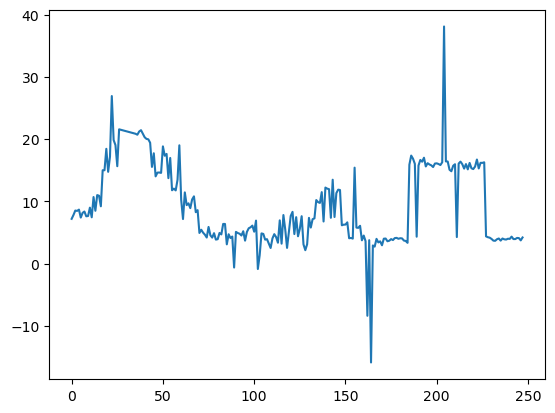

In [33]:
gap_T1[(gap_T1<=60) & (gap_T1>=-60)].mean().sort_index().plot()

In [34]:
pd.DataFrame(gap_T1).to_csv('resultGap1Month.csv')

<Axes: >

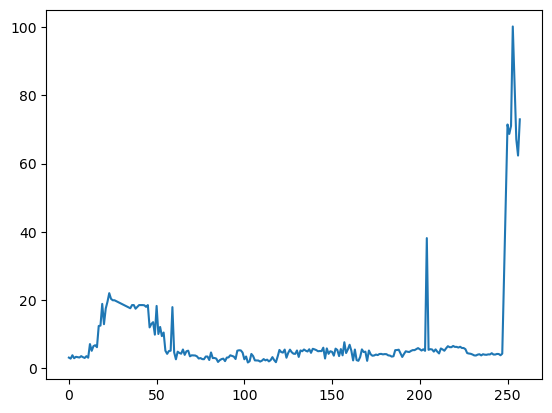

In [37]:
gap_T1.median().sort_index().plot()